## Testing LSTM on VIX

Loading VIX data...
Original data shape: (8924, 5)
Date range: 01/02/1990 to 05/09/2025

VIX Data Statistics:
              OPEN         HIGH          LOW        CLOSE
count  8924.000000  8924.000000  8924.000000  8924.000000
mean     19.582290    20.412310    18.809008    19.489729
std       7.918959     8.405384     7.368506     7.840222
min       2.580000     9.310000     8.560000     9.140000
25%      13.930000    14.530000    13.400000    13.857500
50%      17.690000    18.380000    17.060000    17.635000
75%      22.990000    23.860000    22.152500    22.840000
max      82.690000    89.530000    72.760000    82.690000

Missing values per column:
OPEN     0
HIGH     0
LOW      0
CLOSE    0
dtype: int64
Data shape after removing NaN: (8924, 4)

Using CLOSE as target variable
Target range: 9.14 to 82.69

Model Parameters:
Sequence length: 30 days
Test ratio: 0.2

Scaling data...
Scaled data range: 0.0000 to 1.0000
Creating sequences...
Total sequences created: 8894
Input shape: (889

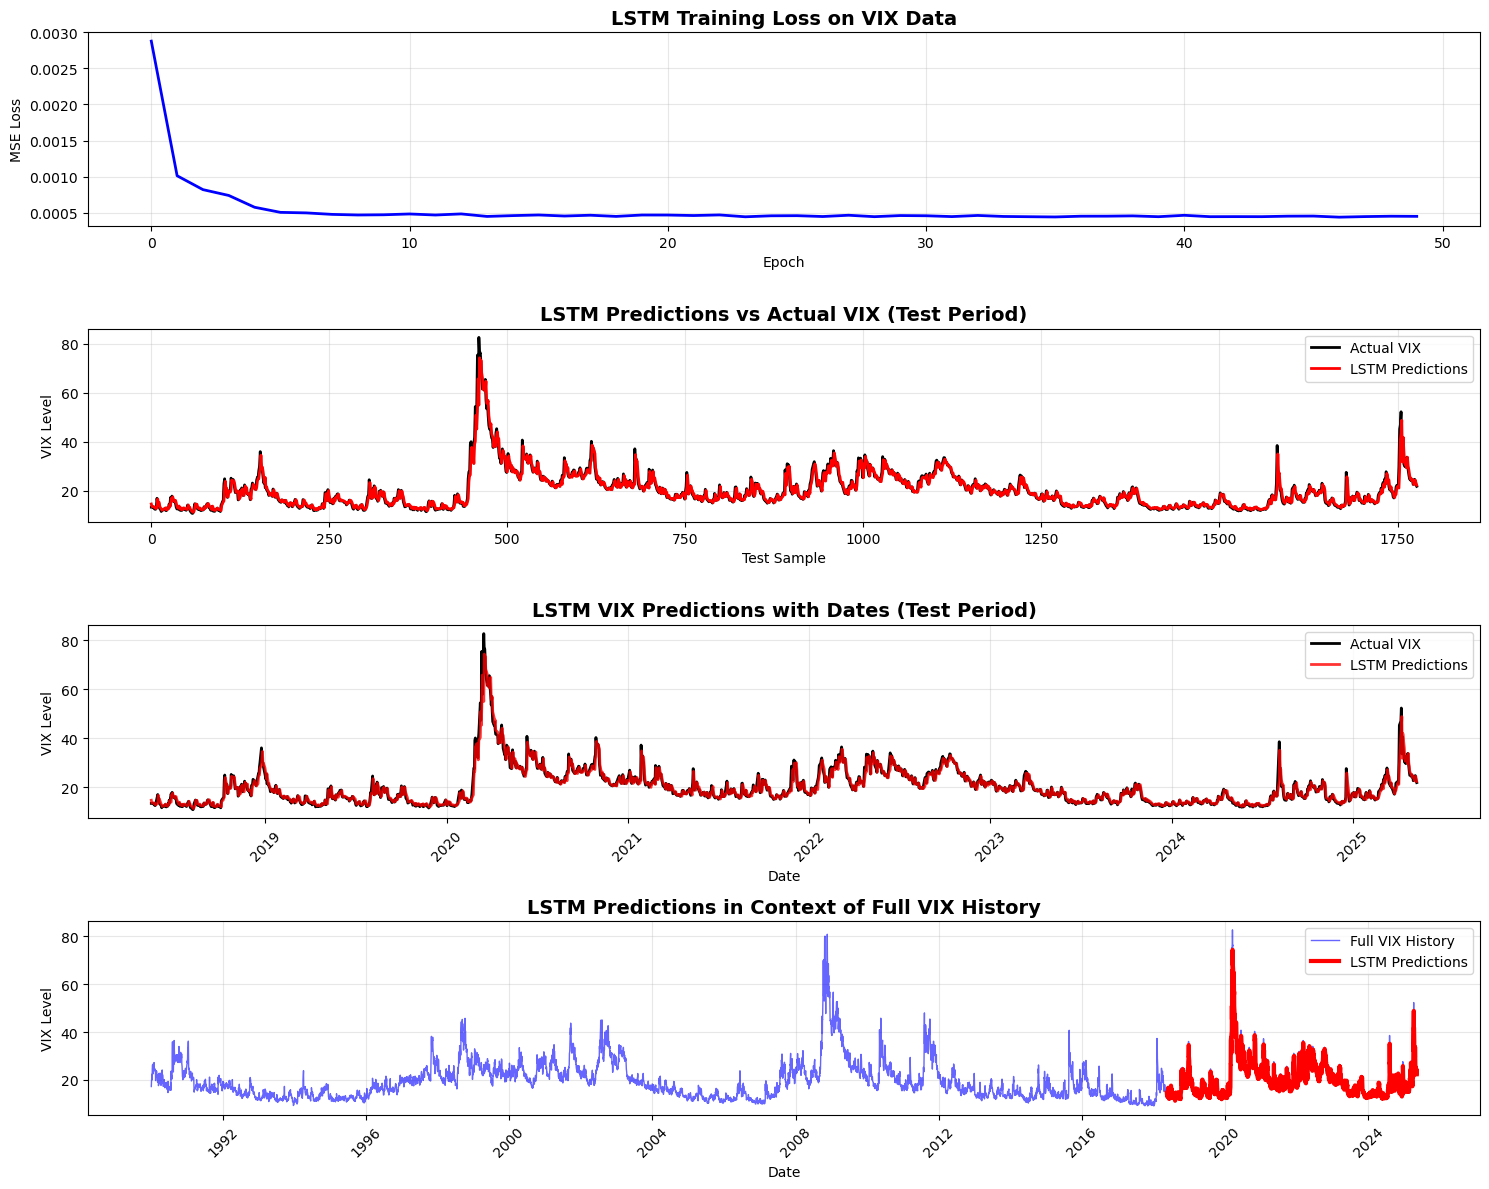

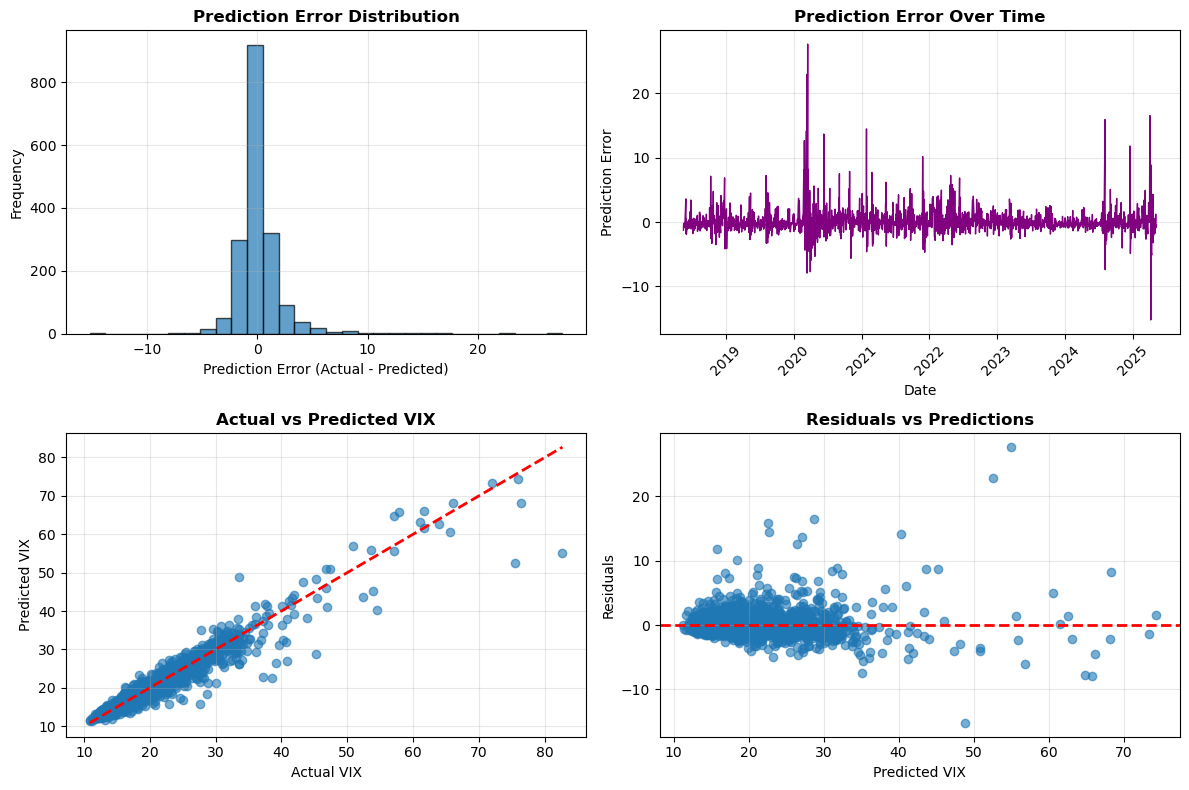


Model Summary:
Dataset: VIX volatility index
Training samples: 7116
Test samples: 1778
Sequence length: 30
Model parameters: 50497
Best metric - RMSE: 2.1009

LSTM testing on VIX dataset completed successfully!
Results stored in 'lstm_results' dictionary for comparison with other models.


In [1]:
# LSTM Model Testing on VIX Dataset
# This script loads VIX data, trains an LSTM model, and evaluates performance

# Import necessary libraries for training
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from models.lstm import LSTMModel

# Load VIX data
print("Loading VIX data...")
vix_data_path = "data/real/cboe_data/VIX_History.csv"
df = pd.read_csv(vix_data_path)

# Data preprocessing
print(f"Original data shape: {df.shape}")
print(f"Date range: {df['DATE'].iloc[0]} to {df['DATE'].iloc[-1]}")

# Convert DATE column to datetime and set as index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Sort by date to ensure chronological order (oldest to newest)
df.sort_index(inplace=True)

# Display basic statistics
print("\nVIX Data Statistics:")
print(df.describe())

# Check for missing values
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Remove any rows with missing values
df.dropna(inplace=True)
print(f"Data shape after removing NaN: {df.shape}")

# Use CLOSE price as our target variable (VIX closing values)
# VIX represents implied volatility, so we're predicting future volatility levels
target_column = 'CLOSE'
print(f"\nUsing {target_column} as target variable")
print(f"Target range: {df[target_column].min():.2f} to {df[target_column].max():.2f}")

# Create sequences function
def create_sequences(data, seq_length):
    """
    Create input sequences and targets for time series prediction
    
    Args:
        data: 1D array of time series values
        seq_length: Length of input sequences (lookback window)
    
    Returns:
        X: Input sequences [num_sequences, seq_length, 1]
        y: Target values [num_sequences, 1]
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Use seq_length previous values to predict next value
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parameters - keep same as original code
sequence_length = 30  # Use 30 days of VIX history to predict the next day
lookforward = 7      # Note: Currently predicting 1 day ahead (can be extended to multi-step)
test_ratio = 0.2     # 20% test split (most recent data for testing)

print(f"\nModel Parameters:")
print(f"Sequence length: {sequence_length} days")
print(f"Test ratio: {test_ratio}")

# Prepare the target data
vix_values = df[target_column].values.reshape(-1, 1)  # Reshape for scaler

# Scale the data using MinMaxScaler (normalizes to 0-1 range)
print("\nScaling data...")
lstm_scaler = MinMaxScaler()
lstm_values_scaled = lstm_scaler.fit_transform(vix_values)

print(f"Scaled data range: {lstm_values_scaled.min():.4f} to {lstm_values_scaled.max():.4f}")

# Create sequences for LSTM input
print("Creating sequences...")
lstm_X, lstm_y = create_sequences(lstm_values_scaled.flatten(), sequence_length)

print(f"Total sequences created: {len(lstm_X)}")
print(f"Input shape: {lstm_X.shape}")  # [num_sequences, seq_length]
print(f"Target shape: {lstm_y.shape}")  # [num_sequences]

# Split into train and test sets (chronological split - no shuffling for time series)
lstm_test_size = int(len(lstm_X) * test_ratio)
lstm_train_size = len(lstm_X) - lstm_test_size

# Split data chronologically (train on older data, test on recent data)
lstm_X_train, lstm_X_test = lstm_X[:lstm_train_size], lstm_X[lstm_train_size:]
lstm_y_train, lstm_y_test = lstm_y[:lstm_train_size], lstm_y[lstm_train_size:]

print(f"\nData split:")
print(f"Training samples: {len(lstm_X_train)}")
print(f"Test samples: {len(lstm_X_test)}")

# Convert to PyTorch tensors and add feature dimension
lstm_X_train = torch.FloatTensor(lstm_X_train).unsqueeze(-1)  # Add feature dimension
lstm_y_train = torch.FloatTensor(lstm_y_train).unsqueeze(-1)  # Add feature dimension
lstm_X_test = torch.FloatTensor(lstm_X_test).unsqueeze(-1)    # Add feature dimension
lstm_y_test = torch.FloatTensor(lstm_y_test).unsqueeze(-1)    # Add feature dimension

print(f"Final tensor shapes:")
print(f"X_train: {lstm_X_train.shape}")  # [num_train, seq_length, 1]
print(f"y_train: {lstm_y_train.shape}")  # [num_train, 1]
print(f"X_test: {lstm_X_test.shape}")    # [num_test, seq_length, 1]
print(f"y_test: {lstm_y_test.shape}")    # [num_test, 1]

# Create data loaders for batch processing
batch_size = 32
lstm_train_dataset = TensorDataset(lstm_X_train, lstm_y_train)
lstm_test_dataset = TensorDataset(lstm_X_test, lstm_y_test)
lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=batch_size, shuffle=True)
lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=batch_size, shuffle=False)

print(f"Created data loaders with batch size: {batch_size}")

# Initialize model, loss function, and optimizer
input_size = 1  # Single feature (VIX close price)
hidden_size = 64  # LSTM hidden state size
num_layers = 2    # Number of LSTM layers
output_size = 1   # Predicting single value (next day VIX)

lstm_model = LSTMModel(input_size=input_size, hidden_size=hidden_size, 
                      num_layers=num_layers, output_size=output_size)
lstm_criterion = nn.MSELoss()  # Mean Squared Error loss
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

print(f"\nModel Architecture:")
print(f"Input size: {input_size}")
print(f"Hidden size: {hidden_size}")
print(f"Number of layers: {num_layers}")
print(f"Output size: {output_size}")
print(f"Total parameters: {sum(p.numel() for p in lstm_model.parameters())}")

# Training
print(f"\nStarting training...")
num_epochs = 50
lstm_train_losses = []
lstm_start_time = time.time()

for epoch in range(num_epochs):
    lstm_model.train()  # Set model to training mode
    lstm_running_loss = 0.0
    
    # Process each batch
    for batch_idx, (inputs, targets) in enumerate(lstm_train_loader):
        # Forward pass
        lstm_outputs = lstm_model(inputs)
        lstm_loss = lstm_criterion(lstm_outputs, targets)
        
        # Backward pass and optimization
        lstm_optimizer.zero_grad()  # Clear gradients
        lstm_loss.backward()        # Compute gradients
        lstm_optimizer.step()       # Update parameters
        
        lstm_running_loss += lstm_loss.item()
    
    # Calculate average loss for this epoch
    lstm_avg_loss = lstm_running_loss / len(lstm_train_loader)
    lstm_train_losses.append(lstm_avg_loss)
    
    # Print progress every 5 epochs
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {lstm_avg_loss:.6f}')

lstm_training_time = time.time() - lstm_start_time
print(f"Training completed in {lstm_training_time:.2f} seconds")

# Evaluation
print(f"\nEvaluating model...")
lstm_model.eval()  # Set model to evaluation mode
lstm_predictions = []
lstm_actuals = []
lstm_inference_start = time.time()

with torch.no_grad():  # Disable gradient computation for efficiency
    for inputs, targets in lstm_test_loader:
        outputs = lstm_model(inputs)
        lstm_predictions.append(outputs.numpy())
        lstm_actuals.append(targets.numpy())
    
    # Concatenate all batch predictions
    lstm_predictions = np.concatenate(lstm_predictions)
    lstm_actuals = np.concatenate(lstm_actuals)
    
    # Inverse transform to original VIX scale
    lstm_predictions = lstm_scaler.inverse_transform(lstm_predictions)
    lstm_actuals = lstm_scaler.inverse_transform(lstm_actuals)

lstm_inference_time = time.time() - lstm_inference_start

# Calculate performance metrics
lstm_mse = mean_squared_error(lstm_actuals, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(lstm_actuals, lstm_predictions)

# Calculate additional financial metrics for VIX prediction
mape = np.mean(np.abs((lstm_actuals - lstm_predictions) / lstm_actuals)) * 100
direction_accuracy = np.mean((np.diff(lstm_actuals.flatten()) > 0) == 
                           (np.diff(lstm_predictions.flatten()) > 0)) * 100

print(f"\nLSTM Performance Metrics on VIX:")
print(f"Test MSE: {lstm_mse:.4f}")
print(f"Test RMSE: {lstm_rmse:.4f}")
print(f"Test MAE: {lstm_mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Direction Accuracy: {direction_accuracy:.2f}%")
print(f"Inference time: {lstm_inference_time:.4f} seconds")

# Create date index for predictions
# Get the corresponding dates for test predictions
test_start_idx = sequence_length + lstm_train_size
test_end_idx = test_start_idx + len(lstm_predictions)
lstm_pred_dates = df.index[test_start_idx:test_end_idx]

print(f"Prediction period: {lstm_pred_dates[0]} to {lstm_pred_dates[-1]}")

# Plot results
plt.figure(figsize=(15, 12))

# Plot 1: Training loss over epochs
plt.subplot(4, 1, 1)
plt.plot(lstm_train_losses, 'b-', linewidth=2)
plt.title('LSTM Training Loss on VIX Data', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)

# Plot 2: Predictions vs actuals (test period only)
plt.subplot(4, 1, 2)
plt.plot(lstm_actuals.flatten(), label='Actual VIX', color='black', linewidth=2)
plt.plot(lstm_predictions.flatten(), label='LSTM Predictions', color='red', linewidth=2)
plt.title('LSTM Predictions vs Actual VIX (Test Period)', fontsize=14, fontweight='bold')
plt.xlabel('Test Sample')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Predictions with dates (test period)
plt.subplot(4, 1, 3)
plt.plot(lstm_pred_dates, lstm_actuals.flatten(), label='Actual VIX', 
         color='black', linewidth=2)
plt.plot(lstm_pred_dates, lstm_predictions.flatten(), label='LSTM Predictions', 
         color='red', linewidth=2, alpha=0.8)
plt.title('LSTM VIX Predictions with Dates (Test Period)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 4: Full dataset context with predictions
plt.subplot(4, 1, 4)
plt.plot(df.index, df[target_column], label='Full VIX History', 
         color='blue', alpha=0.6, linewidth=1)
plt.plot(lstm_pred_dates, lstm_predictions.flatten(), label='LSTM Predictions', 
         color='red', linewidth=3)
plt.title('LSTM Predictions in Context of Full VIX History', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Additional analysis: Prediction errors
plt.figure(figsize=(12, 8))

# Plot error distribution
plt.subplot(2, 2, 1)
errors = lstm_actuals.flatten() - lstm_predictions.flatten()
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.title('Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot error over time
plt.subplot(2, 2, 2)
plt.plot(lstm_pred_dates, errors, color='purple', linewidth=1)
plt.title('Prediction Error Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Scatter plot: Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(lstm_actuals.flatten(), lstm_predictions.flatten(), alpha=0.6)
plt.plot([lstm_actuals.min(), lstm_actuals.max()], 
         [lstm_actuals.min(), lstm_actuals.max()], 'r--', linewidth=2)
plt.title('Actual vs Predicted VIX', fontsize=12, fontweight='bold')
plt.xlabel('Actual VIX')
plt.ylabel('Predicted VIX')
plt.grid(True, alpha=0.3)

# Residuals plot
plt.subplot(2, 2, 4)
plt.scatter(lstm_predictions.flatten(), errors, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals vs Predictions', fontsize=12, fontweight='bold')
plt.xlabel('Predicted VIX')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for later comparison with other models
lstm_results = {
    'model': 'LSTM',
    'dataset': 'VIX',
    'mse': lstm_mse,
    'rmse': lstm_rmse,
    'mae': lstm_mae,
    'mape': mape,
    'direction_accuracy': direction_accuracy,
    'training_time': lstm_training_time,
    'inference_time': lstm_inference_time,
    'predictions': lstm_predictions,
    'actuals': lstm_actuals,
    'prediction_dates': lstm_pred_dates,
    'errors': errors,
    'num_parameters': sum(p.numel() for p in lstm_model.parameters())
}

print(f"\nModel Summary:")
print(f"Dataset: VIX volatility index")
print(f"Training samples: {len(lstm_X_train)}")
print(f"Test samples: {len(lstm_X_test)}")
print(f"Sequence length: {sequence_length}")
print(f"Model parameters: {lstm_results['num_parameters']}")
print(f"Best metric - RMSE: {lstm_rmse:.4f}")

# Save results (optional)
# import pickle
# with open('lstm_vix_results.pkl', 'wb') as f:
#     pickle.dump(lstm_results, f)

print(f"\nLSTM testing on VIX dataset completed successfully!")
print(f"Results stored in 'lstm_results' dictionary for comparison with other models.")

NBEATSX MODEL TESTING ON VIX DATASET
NBEATSx Parameters:
Lookback window: 30 days
Forecast horizon: 1 day
Test ratio: 0.2

Preparing VIX data for NBEATSx model...
Creating exogenous features from VIX data...
Created exogenous features. New dataframe shape: (8924, 28)
After removing NaN values: (8905, 28)
Using 19 exogenous features:
   1. day_of_week_sin
   2. day_of_week_cos
   3. day_of_month_sin
   4. day_of_month_cos
   5. month_sin
   6. month_cos
   7. vix_range
   8. vix_change
   9. vix_pct_change
  10. vix_ma_5
  11. vix_ma_10
  12. vix_ma_20
  13. vix_vol_5
  14. vix_vol_10
  15. is_weekend
  16. is_month_end
  17. is_quarter_end
  18. vix_low_regime
  19. vix_high_regime

Target data shape: (8905,)
Exogenous data shape: (8905, 19)
Target range: 9.14 to 82.69
Data scaling completed.
Scaled target range: -1.3183 to 8.0566

Creating sequences for NBEATSx...
Sequences created:
  Input sequences (X): (8875, 30)
  Target values (y): (8875,)
  Exogenous data: (8875, 31, 19)

Data s

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch [ 5/50], Loss: 27.976647
Epoch [10/50], Loss: 3.410828
Epoch [15/50], Loss: 3.664187
Epoch [20/50], Loss: 0.976026
Epoch [25/50], Loss: 1.237393
Epoch [30/50], Loss: 2005.173913
Epoch [35/50], Loss: 241.086651
Epoch [40/50], Loss: 104.821463
Epoch [45/50], Loss: 35.222690
Epoch [50/50], Loss: 13.236596

NBEATSx training completed in 4456.69 seconds

Evaluating NBEATSx model...
Inference completed in 22.6544 seconds
Predictions transformed back to original scale.

NBEATSx Performance Metrics on VIX:
Test MSE: 160.9109
Test RMSE: 12.6851
Test MAE: 7.0667
MAPE: 32.92%
Direction Accuracy: 57.05%
Training time: 4456.69 seconds
Inference time: 22.6544 seconds
Prediction period: 2018-05-21 00:00:00 to 2025-05-09 00:00:00


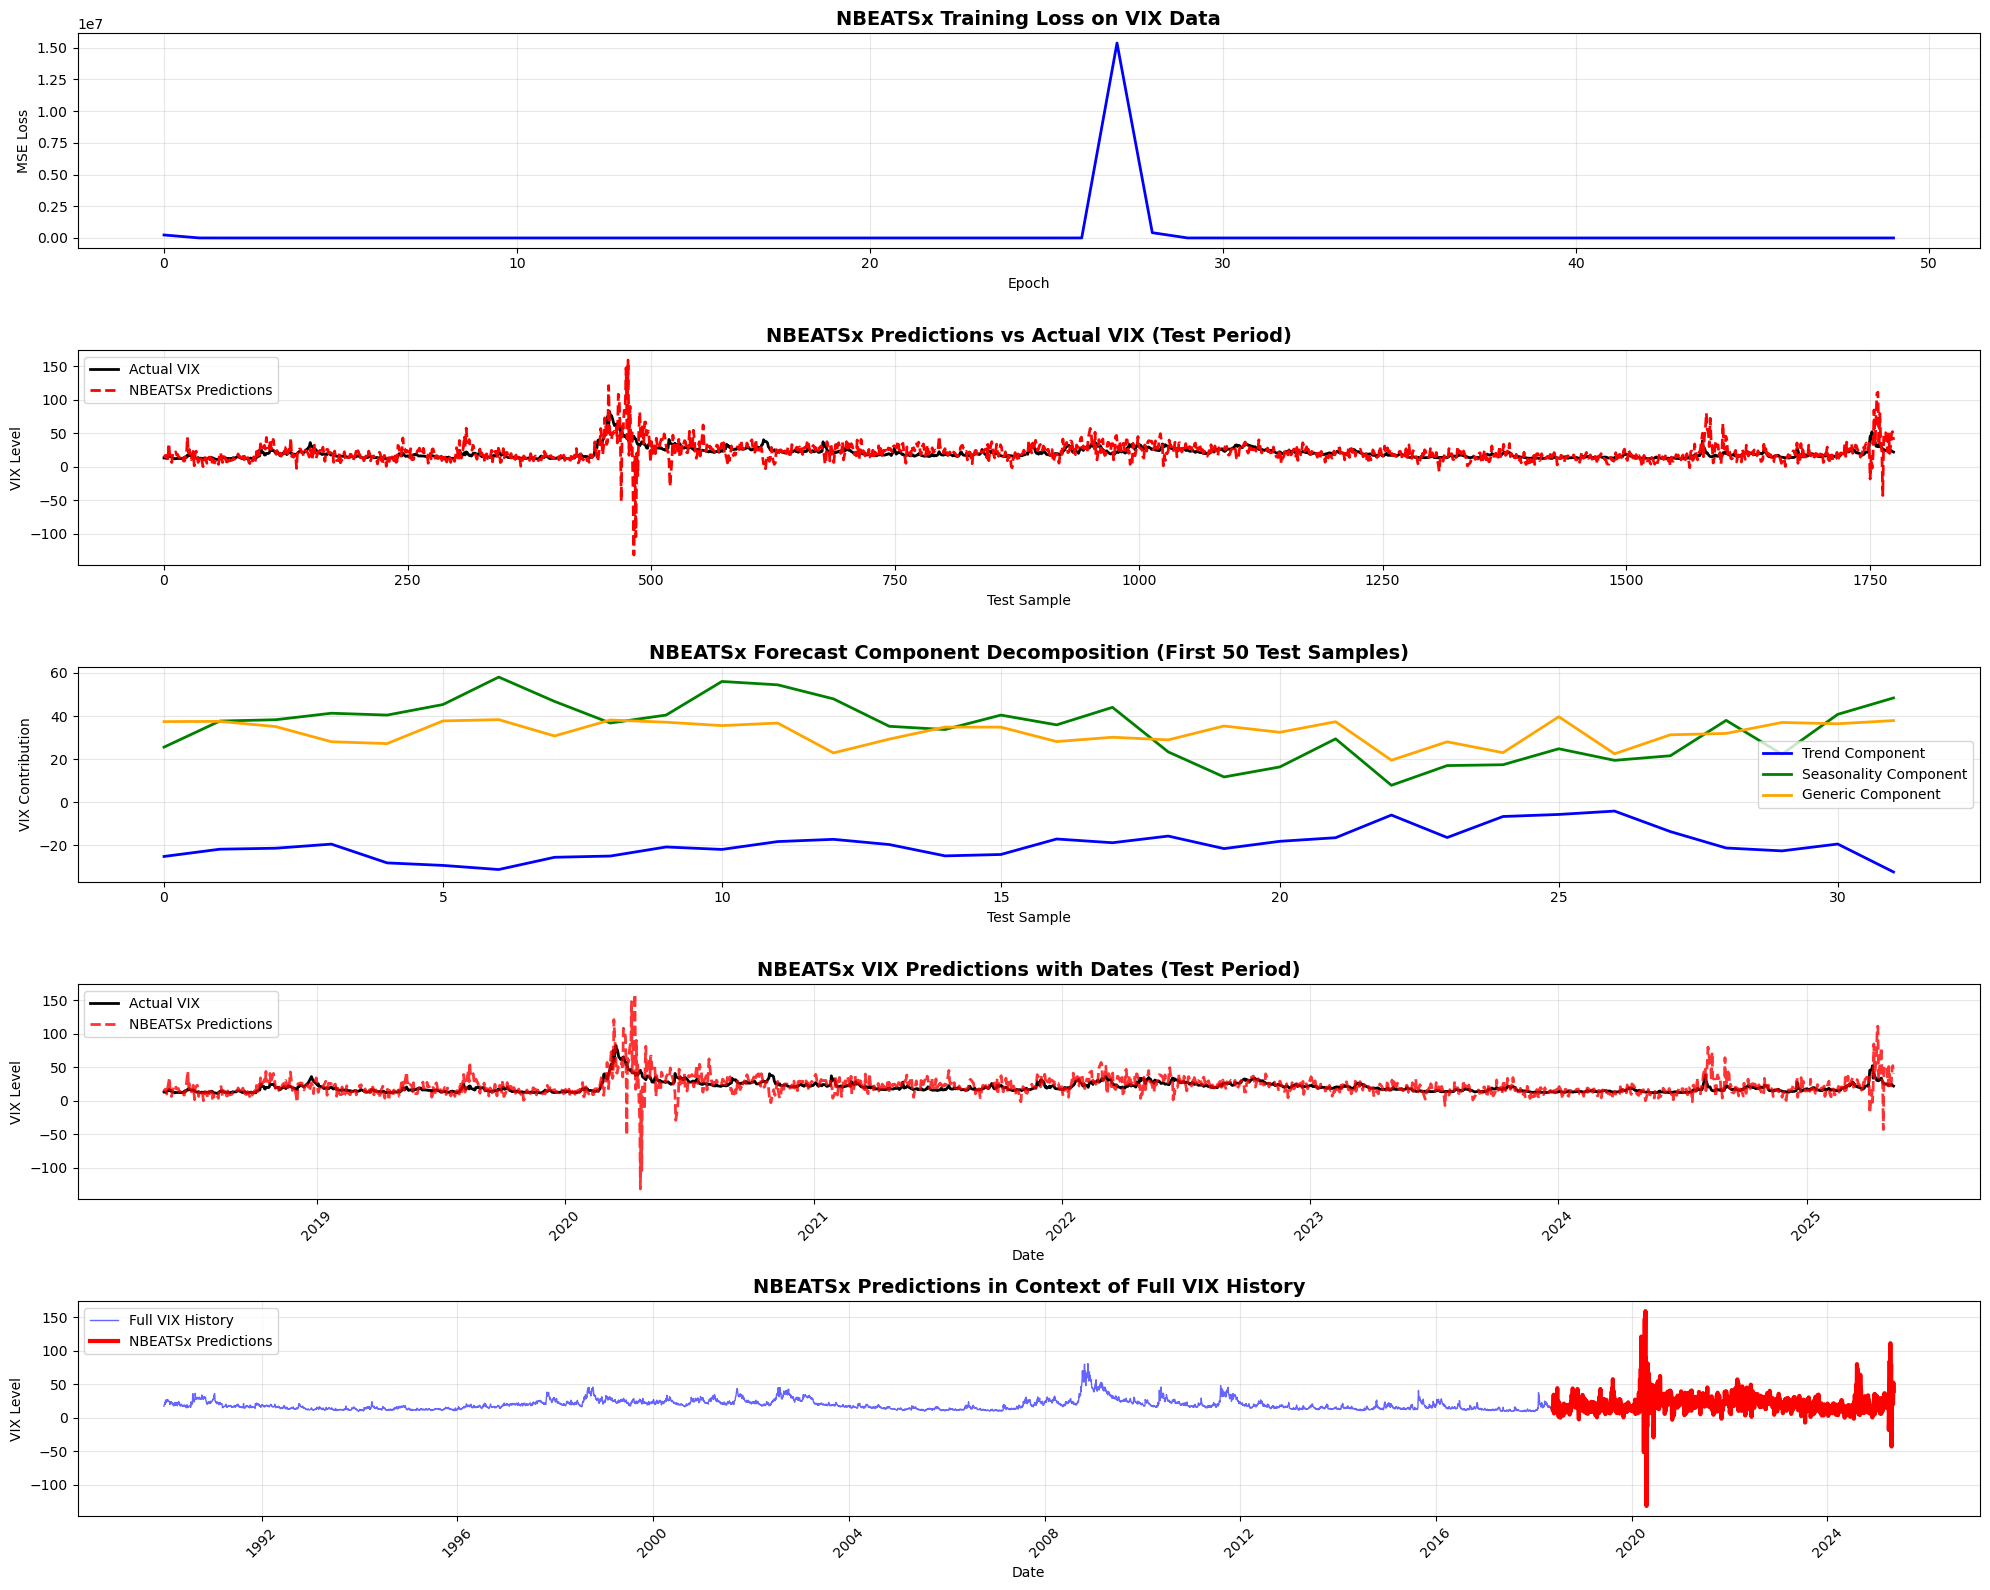

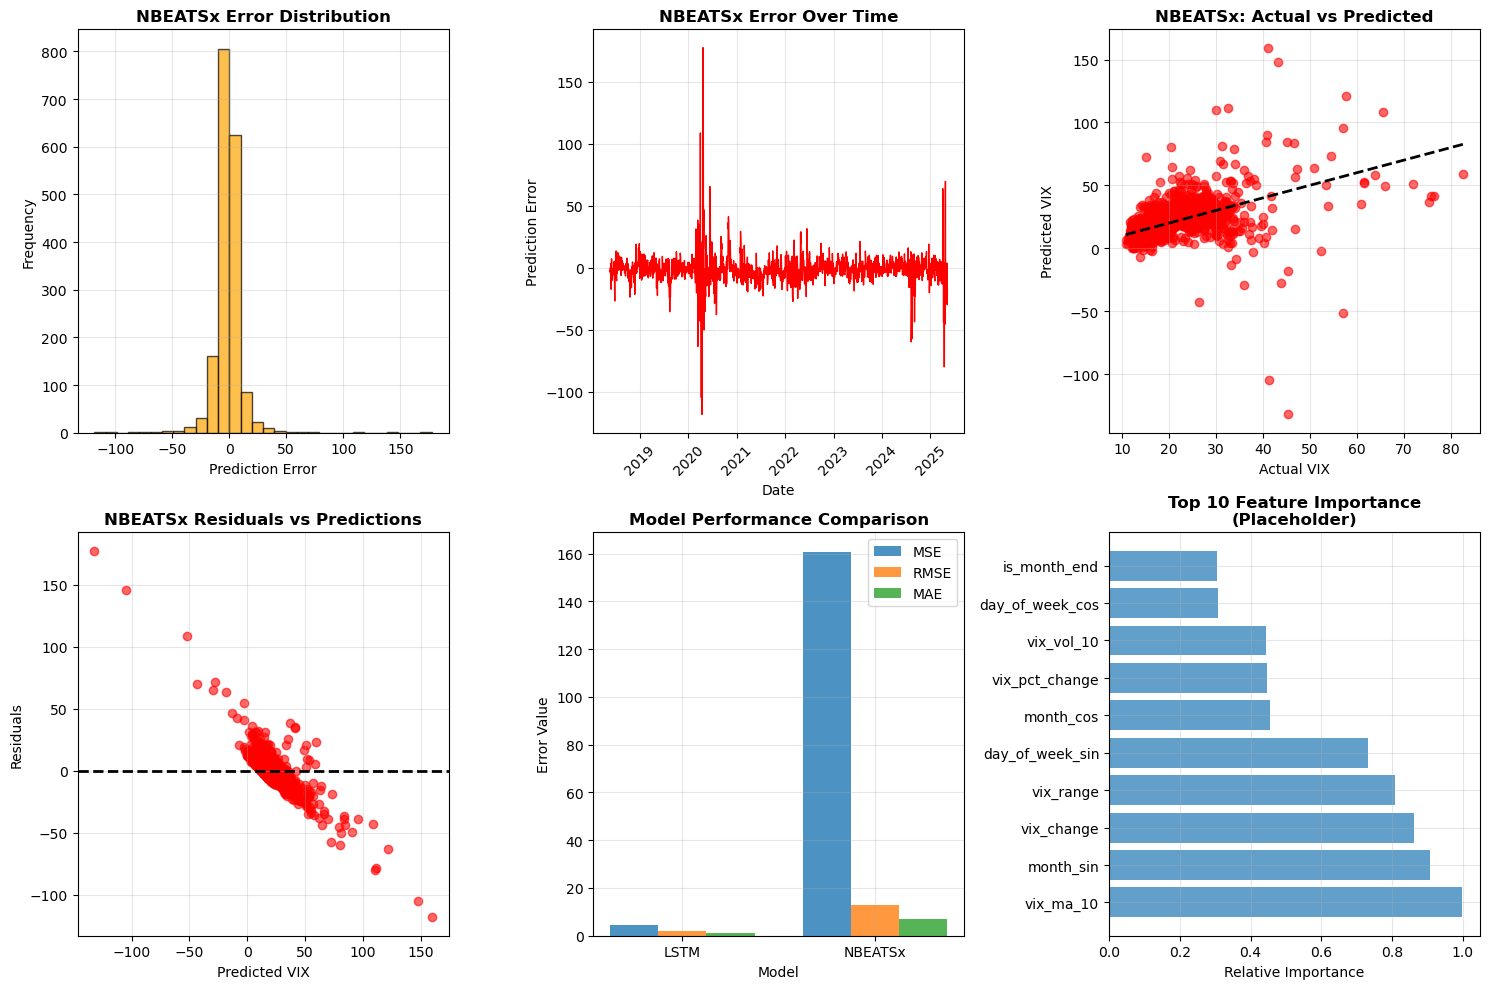


MODEL COMPARISON SUMMARY
  Model      MSE    RMSE    MAE MAPE (%) Direction Acc (%) Training Time (s) Parameters
   LSTM   4.4139  2.1009 1.1888     5.41             48.17             95.09     50,497
NBEATSx 160.9109 12.6851 7.0667    32.92             57.05           4456.69  1,648,832

------------------------------------------------------------
📉 LSTM outperformed NBEATSx by 503.78% (RMSE advantage)
NBEATSx benefits:
  ✓ Interpretable components (trend, seasonality, generic)
  ✓ Uses 19 exogenous features vs LSTM's 1
  ✓ Built specifically for time series forecasting
  ✓ Component decomposition for explainability
LSTM benefits:
  ✓ Simpler architecture (50,497 vs 1,648,832 parameters)
  ✓ Faster training (95.1s vs 4456.7s)
  ✓ More established and well-understood

NBEATSX ANALYSIS COMPLETE

NBEATSx Key Insights:
1. Model successfully trained on 7,100 VIX samples
2. Achieved 12.6851 RMSE on 1,775 test samples
3. Direction accuracy: 57.0% (important for trading)
4. Leveraged 19 time

In [2]:
# Cell 2: NBEATSx Model Testing on VIX Dataset
# This cell trains and evaluates NBEATSx model for VIX volatility prediction

# Import necessary libraries for NBEATSx training
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import time
import matplotlib.pyplot as plt
from models.nbeatsx_v7 import NBEATSx

print("="*60)
print("NBEATSX MODEL TESTING ON VIX DATASET")
print("="*60)

# Parameters - modified for VIX single-step forecasting
nbeatsx_lookback = 30  # Use 30 days of VIX history (same as LSTM)
nbeatsx_forecast_horizon = 1  # Single-step: predict only 1 day ahead
nbeatsx_test_ratio = 0.2  # Same test split as LSTM

print(f"NBEATSx Parameters:")
print(f"Lookback window: {nbeatsx_lookback} days")
print(f"Forecast horizon: {nbeatsx_forecast_horizon} day")
print(f"Test ratio: {nbeatsx_test_ratio}")

# Prepare data for NBEATSx
print(f"\nPreparing VIX data for NBEATSx model...")

# Use the same VIX data that was loaded in the LSTM cell
# Target variable: VIX CLOSE price
target_col = 'CLOSE'

# Create additional time-based features for NBEATSx (exogenous variables)
# NBEATSx can leverage multiple input features unlike basic LSTM
print("Creating exogenous features from VIX data...")

# Create a copy of the dataframe for feature engineering
nbeatsx_df = df.copy()

# Extract time-based features from the date index
nbeatsx_df['day_of_week'] = nbeatsx_df.index.dayofweek  # 0=Monday, 6=Sunday
nbeatsx_df['day_of_month'] = nbeatsx_df.index.day
nbeatsx_df['month'] = nbeatsx_df.index.month
nbeatsx_df['quarter'] = nbeatsx_df.index.quarter
nbeatsx_df['year'] = nbeatsx_df.index.year

# Create cyclical features (important for time series)
# Sine/cosine encoding preserves cyclical nature of time features
nbeatsx_df['day_of_week_sin'] = np.sin(2 * np.pi * nbeatsx_df['day_of_week'] / 7)
nbeatsx_df['day_of_week_cos'] = np.cos(2 * np.pi * nbeatsx_df['day_of_week'] / 7)
nbeatsx_df['day_of_month_sin'] = np.sin(2 * np.pi * nbeatsx_df['day_of_month'] / 31)
nbeatsx_df['day_of_month_cos'] = np.cos(2 * np.pi * nbeatsx_df['day_of_month'] / 31)
nbeatsx_df['month_sin'] = np.sin(2 * np.pi * nbeatsx_df['month'] / 12)
nbeatsx_df['month_cos'] = np.cos(2 * np.pi * nbeatsx_df['month'] / 12)

# Create financial features specific to VIX
# VIX-specific features that might help prediction
nbeatsx_df['vix_range'] = nbeatsx_df['HIGH'] - nbeatsx_df['LOW']  # Daily volatility range
nbeatsx_df['vix_change'] = nbeatsx_df['CLOSE'].diff()  # Day-to-day change
nbeatsx_df['vix_pct_change'] = nbeatsx_df['CLOSE'].pct_change()  # Percentage change

# Technical indicators
# Rolling averages to capture trends
nbeatsx_df['vix_ma_5'] = nbeatsx_df['CLOSE'].rolling(window=5).mean()
nbeatsx_df['vix_ma_10'] = nbeatsx_df['CLOSE'].rolling(window=10).mean()
nbeatsx_df['vix_ma_20'] = nbeatsx_df['CLOSE'].rolling(window=20).mean()

# Volatility of volatility (VIX is already a volatility measure)
nbeatsx_df['vix_vol_5'] = nbeatsx_df['CLOSE'].rolling(window=5).std()
nbeatsx_df['vix_vol_10'] = nbeatsx_df['CLOSE'].rolling(window=10).std()

# Binary features
nbeatsx_df['is_weekend'] = (nbeatsx_df['day_of_week'] >= 5).astype(int)  # Saturday=5, Sunday=6
nbeatsx_df['is_month_end'] = (nbeatsx_df['day_of_month'] >= 28).astype(int)
nbeatsx_df['is_quarter_end'] = nbeatsx_df['month'].isin([3, 6, 9, 12]).astype(int)

# VIX regime indicators (low/normal/high volatility periods)
vix_quantiles = nbeatsx_df['CLOSE'].quantile([0.33, 0.67])
nbeatsx_df['vix_low_regime'] = (nbeatsx_df['CLOSE'] <= vix_quantiles.iloc[0]).astype(int)
nbeatsx_df['vix_high_regime'] = (nbeatsx_df['CLOSE'] >= vix_quantiles.iloc[1]).astype(int)

print(f"Created exogenous features. New dataframe shape: {nbeatsx_df.shape}")

# Remove rows with NaN values (created by rolling windows and diff operations)
nbeatsx_df.dropna(inplace=True)
print(f"After removing NaN values: {nbeatsx_df.shape}")

# Define exogenous feature columns (everything except OHLC)
exog_cols = [
    'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos',
    'month_sin', 'month_cos', 'vix_range', 'vix_change', 'vix_pct_change',
    'vix_ma_5', 'vix_ma_10', 'vix_ma_20', 'vix_vol_5', 'vix_vol_10',
    'is_weekend', 'is_month_end', 'is_quarter_end', 'vix_low_regime', 'vix_high_regime'
]

print(f"Using {len(exog_cols)} exogenous features:")
for i, col in enumerate(exog_cols):
    print(f"  {i+1:2d}. {col}")

# Prepare target and exogenous data
target_data = nbeatsx_df[target_col].values
exog_data = nbeatsx_df[exog_cols].values

print(f"\nTarget data shape: {target_data.shape}")
print(f"Exogenous data shape: {exog_data.shape}")
print(f"Target range: {target_data.min():.2f} to {target_data.max():.2f}")

# Scale target variable (VIX CLOSE prices)
nbeatsx_scaler_y = StandardScaler()
nbeatsx_y_scaled = nbeatsx_scaler_y.fit_transform(target_data.reshape(-1, 1))

# Scale exogenous variables
nbeatsx_scaler_x = StandardScaler()
nbeatsx_exog_scaled = nbeatsx_scaler_x.fit_transform(exog_data)

print(f"Data scaling completed.")
print(f"Scaled target range: {nbeatsx_y_scaled.min():.4f} to {nbeatsx_y_scaled.max():.4f}")

# Create sequences for NBEATSx (modified for single-step forecasting)
def create_nbeatsx_sequences(target_data, exog_data, lookback, horizon=1):
    """
    Create input sequences for NBEATSx model
    
    Args:
        target_data: Scaled target time series [n_samples, 1]
        exog_data: Scaled exogenous features [n_samples, n_features]
        lookback: Number of historical time steps to use as input
        horizon: Number of future time steps to predict (default=1)
    
    Returns:
        X: Input sequences [n_sequences, lookback]
        y: Target values [n_sequences] (single values for horizon=1)
        exog: Exogenous sequences [n_sequences, lookback + horizon, n_features]
    """
    X, y, exog = [], [], []
    
    for i in range(len(target_data) - lookback - horizon + 1):
        # Historical target sequence (input to model)
        X.append(target_data[i:i+lookback, 0])
        
        # Target value (what we want to predict)
        y.append(target_data[i+lookback, 0])  # Single value for next day
        
        # Exogenous variables: historical + future (for next day prediction)
        # NBEATSx needs exog features for both input period and forecast period
        exog_sequence = exog_data[i:i+lookback+horizon]
        exog.append(exog_sequence)
    
    return np.array(X), np.array(y), np.array(exog)

# Create sequences
print(f"\nCreating sequences for NBEATSx...")
nbeatsx_X, nbeatsx_y, nbeatsx_exog = create_nbeatsx_sequences(
    nbeatsx_y_scaled, nbeatsx_exog_scaled, nbeatsx_lookback, nbeatsx_forecast_horizon)

print(f"Sequences created:")
print(f"  Input sequences (X): {nbeatsx_X.shape}")  # [n_sequences, lookback]
print(f"  Target values (y): {nbeatsx_y.shape}")    # [n_sequences]
print(f"  Exogenous data: {nbeatsx_exog.shape}")    # [n_sequences, lookback+horizon, n_features]

# Split into train and test sets (chronological split)
nbeatsx_test_size = int(len(nbeatsx_X) * nbeatsx_test_ratio)
nbeatsx_train_size = len(nbeatsx_X) - nbeatsx_test_size

# Training data (older time periods)
nbeatsx_X_train = nbeatsx_X[:nbeatsx_train_size]
nbeatsx_y_train = nbeatsx_y[:nbeatsx_train_size]
nbeatsx_exog_train = nbeatsx_exog[:nbeatsx_train_size]

# Test data (recent time periods)
nbeatsx_X_test = nbeatsx_X[nbeatsx_train_size:]
nbeatsx_y_test = nbeatsx_y[nbeatsx_train_size:]
nbeatsx_exog_test = nbeatsx_exog[nbeatsx_train_size:]

print(f"\nData split:")
print(f"  Training samples: {nbeatsx_train_size}")
print(f"  Test samples: {nbeatsx_test_size}")

# Convert to PyTorch tensors
nbeatsx_X_train_tensor = torch.FloatTensor(nbeatsx_X_train)
nbeatsx_y_train_tensor = torch.FloatTensor(nbeatsx_y_train)
nbeatsx_exog_train_tensor = torch.FloatTensor(nbeatsx_exog_train)

nbeatsx_X_test_tensor = torch.FloatTensor(nbeatsx_X_test)
nbeatsx_y_test_tensor = torch.FloatTensor(nbeatsx_y_test)
nbeatsx_exog_test_tensor = torch.FloatTensor(nbeatsx_exog_test)

print(f"Converted to PyTorch tensors.")

# Create data loaders for batch processing
batch_size = 32
nbeatsx_train_dataset = TensorDataset(nbeatsx_X_train_tensor, nbeatsx_y_train_tensor, nbeatsx_exog_train_tensor)
nbeatsx_test_dataset = TensorDataset(nbeatsx_X_test_tensor, nbeatsx_y_test_tensor, nbeatsx_exog_test_tensor)

nbeatsx_train_loader = DataLoader(nbeatsx_train_dataset, batch_size=batch_size, shuffle=True)
nbeatsx_test_loader = DataLoader(nbeatsx_test_dataset, batch_size=batch_size, shuffle=False)

print(f"Created data loaders with batch size: {batch_size}")

# Initialize the NBEATSx model
exog_channels = nbeatsx_exog.shape[2]  # Number of exogenous features

print(f"\nInitializing NBEATSx model...")
print(f"Model configuration:")
print(f"  Input size: {nbeatsx_lookback}")
print(f"  Forecast size: {nbeatsx_forecast_horizon}")
print(f"  Exogenous channels: {exog_channels}")

# Initialize the enhanced NBEATSx model
nbeatsx_model = NBEATSx(
    input_size=nbeatsx_lookback,
    forecast_size=nbeatsx_forecast_horizon,
    exog_channels=exog_channels,
    stack_types=['trend', 'seasonality', 'generic'],  # Three interpretable stacks
    num_blocks_per_stack=[2, 2, 1],  # Blocks per stack
    hidden_units=128,  # Hidden layer size
    layers=3,  # Layers per block
    basis_kwargs={
        'degree': 3,  # Polynomial degree for trend
        'harmonics': 5,  # Fourier harmonics for seasonality
        'tcn_levels': 3,  # TCN depth for exogenous processing
        'tcn_kernel_size': 3  # TCN kernel size
    },
    dropout=0.1,  # Dropout rate
    exog_mode='tcn'  # Use TCN for exogenous variable processing
)

# Count model parameters
total_params = sum(p.numel() for p in nbeatsx_model.parameters())
trainable_params = sum(p.numel() for p in nbeatsx_model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Loss function and optimizer
nbeatsx_criterion = nn.MSELoss()
nbeatsx_optimizer = optim.Adam(nbeatsx_model.parameters(), lr=0.001)

print(f"Loss function: MSE")
print(f"Optimizer: Adam (lr=0.001)")

# Training
num_epochs = 50
nbeatsx_train_losses = []
nbeatsx_start_time = time.time()

print(f"\nStarting NBEATSx training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    nbeatsx_model.train()  # Set model to training mode
    nbeatsx_running_loss = 0.0
    
    # Process each batch
    for batch_idx, (inputs, targets, exog) in enumerate(nbeatsx_train_loader):
        # Forward pass through NBEATSx
        nbeatsx_outputs = nbeatsx_model(inputs, exog)
        
        # Reshape outputs to match targets
        # NBEATSx outputs [batch_size, forecast_horizon], targets are [batch_size]
        nbeatsx_outputs = nbeatsx_outputs.squeeze()  # Remove extra dimensions
        
        # Calculate loss
        nbeatsx_loss = nbeatsx_criterion(nbeatsx_outputs, targets)
        
        # Backward pass and optimization
        nbeatsx_optimizer.zero_grad()  # Clear gradients
        nbeatsx_loss.backward()  # Compute gradients
        nbeatsx_optimizer.step()  # Update parameters
        
        nbeatsx_running_loss += nbeatsx_loss.item()
    
    # Calculate average loss for this epoch
    nbeatsx_avg_loss = nbeatsx_running_loss / len(nbeatsx_train_loader)
    nbeatsx_train_losses.append(nbeatsx_avg_loss)
    
    # Print progress every 5 epochs
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1:2d}/{num_epochs}], Loss: {nbeatsx_avg_loss:.6f}')

nbeatsx_training_time = time.time() - nbeatsx_start_time
print(f"\nNBEATSx training completed in {nbeatsx_training_time:.2f} seconds")

# Evaluation with component decomposition
print(f"\nEvaluating NBEATSx model...")
nbeatsx_model.eval()  # Set model to evaluation mode
nbeatsx_predictions = []
nbeatsx_actuals = []
nbeatsx_components = []
nbeatsx_inference_start = time.time()

with torch.no_grad():  # Disable gradient computation for efficiency
    for batch_idx, (inputs, targets, exog) in enumerate(nbeatsx_test_loader):
        # Get prediction with component decomposition (trend, seasonality, generic)
        outputs, components = nbeatsx_model(inputs, exog, return_decomposition=True)
        
        # Store predictions (squeeze to remove extra dimensions)
        nbeatsx_predictions.append(outputs.squeeze().numpy())
        nbeatsx_actuals.append(targets.numpy())
        
        # Store components for the first batch only (for visualization)
        if len(nbeatsx_components) == 0:
            nbeatsx_components = [comp.squeeze().numpy() for comp in components]

nbeatsx_inference_time = time.time() - nbeatsx_inference_start

print(f"Inference completed in {nbeatsx_inference_time:.4f} seconds")

# Concatenate all batch predictions
nbeatsx_predictions = np.concatenate(nbeatsx_predictions)
nbeatsx_actuals = np.concatenate(nbeatsx_actuals)

# Reshape for inverse scaling
nbeatsx_predictions_reshaped = nbeatsx_predictions.reshape(-1, 1)
nbeatsx_actuals_reshaped = nbeatsx_actuals.reshape(-1, 1)

# Inverse transform to original VIX scale
nbeatsx_predictions_orig = nbeatsx_scaler_y.inverse_transform(nbeatsx_predictions_reshaped).flatten()
nbeatsx_actuals_orig = nbeatsx_scaler_y.inverse_transform(nbeatsx_actuals_reshaped).flatten()

print(f"Predictions transformed back to original scale.")

# Calculate performance metrics
nbeatsx_mse = mean_squared_error(nbeatsx_actuals_orig, nbeatsx_predictions_orig)
nbeatsx_rmse = np.sqrt(nbeatsx_mse)
nbeatsx_mae = mean_absolute_error(nbeatsx_actuals_orig, nbeatsx_predictions_orig)

# Additional financial metrics
nbeatsx_mape = np.mean(np.abs((nbeatsx_actuals_orig - nbeatsx_predictions_orig) / nbeatsx_actuals_orig)) * 100
nbeatsx_direction_accuracy = np.mean((np.diff(nbeatsx_actuals_orig) > 0) == 
                                   (np.diff(nbeatsx_predictions_orig) > 0)) * 100

print(f"\nNBEATSx Performance Metrics on VIX:")
print(f"Test MSE: {nbeatsx_mse:.4f}")
print(f"Test RMSE: {nbeatsx_rmse:.4f}")
print(f"Test MAE: {nbeatsx_mae:.4f}")
print(f"MAPE: {nbeatsx_mape:.2f}%")
print(f"Direction Accuracy: {nbeatsx_direction_accuracy:.2f}%")
print(f"Training time: {nbeatsx_training_time:.2f} seconds")
print(f"Inference time: {nbeatsx_inference_time:.4f} seconds")

# Calculate prediction dates
# Account for the data lost due to feature engineering and sequence creation
data_offset = len(df) - len(nbeatsx_df)  # Rows lost due to NaN removal
start_idx = data_offset + nbeatsx_lookback + nbeatsx_train_size
end_idx = start_idx + len(nbeatsx_predictions_orig)

# Use the cleaned dataframe index for dates
nbeatsx_pred_dates = nbeatsx_df.index[nbeatsx_lookback + nbeatsx_train_size:
                                      nbeatsx_lookback + nbeatsx_train_size + len(nbeatsx_predictions_orig)]

print(f"Prediction period: {nbeatsx_pred_dates[0]} to {nbeatsx_pred_dates[-1]}")

# Comprehensive visualization
plt.figure(figsize=(20, 16))

# 1. Training loss over epochs
plt.subplot(5, 1, 1)
plt.plot(nbeatsx_train_losses, 'b-', linewidth=2)
plt.title('NBEATSx Training Loss on VIX Data', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)

# 2. Predictions vs actuals (test period)
plt.subplot(5, 1, 2)
plt.plot(nbeatsx_actuals_orig, label='Actual VIX', color='black', linewidth=2)
plt.plot(nbeatsx_predictions_orig, label='NBEATSx Predictions', color='red', linewidth=2, linestyle='--')
plt.title('NBEATSx Predictions vs Actual VIX (Test Period)', fontsize=14, fontweight='bold')
plt.xlabel('Test Sample')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Component decomposition (NBEATSx interpretability feature)
plt.subplot(5, 1, 3)
component_labels = ['Trend', 'Seasonality', 'Generic']
colors = ['blue', 'green', 'orange']

for i, (comp_label, color) in enumerate(zip(component_labels, colors)):
    if i < len(nbeatsx_components):
        # Get first 50 components for better visualization
        comp_values = nbeatsx_components[i][:50]
        # Reshape and inverse transform for interpretability
        comp_reshaped = comp_values.reshape(-1, 1)
        comp_orig = nbeatsx_scaler_y.inverse_transform(comp_reshaped).flatten()
        plt.plot(comp_orig, label=f'{comp_label} Component', color=color, linewidth=2)

plt.title('NBEATSx Forecast Component Decomposition (First 50 Test Samples)', fontsize=14, fontweight='bold')
plt.xlabel('Test Sample')
plt.ylabel('VIX Contribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Predictions with dates
plt.subplot(5, 1, 4)
plt.plot(nbeatsx_pred_dates, nbeatsx_actuals_orig, label='Actual VIX', 
         color='black', linewidth=2)
plt.plot(nbeatsx_pred_dates, nbeatsx_predictions_orig, label='NBEATSx Predictions', 
         color='red', linewidth=2, linestyle='--', alpha=0.8)
plt.title('NBEATSx VIX Predictions with Dates (Test Period)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 5. Full dataset context with predictions
plt.subplot(5, 1, 5)
plt.plot(df.index, df['CLOSE'], label='Full VIX History', 
         color='blue', alpha=0.6, linewidth=1)
plt.plot(nbeatsx_pred_dates, nbeatsx_predictions_orig, label='NBEATSx Predictions', 
         color='red', linewidth=3)
plt.title('NBEATSx Predictions in Context of Full VIX History', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Additional analysis: Error analysis and model comparison
plt.figure(figsize=(15, 10))

# Error distribution
plt.subplot(2, 3, 1)
nbeatsx_errors = nbeatsx_actuals_orig - nbeatsx_predictions_orig
plt.hist(nbeatsx_errors, bins=30, alpha=0.7, edgecolor='black', color='orange')
plt.title('NBEATSx Error Distribution', fontweight='bold')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Error over time
plt.subplot(2, 3, 2)
plt.plot(nbeatsx_pred_dates, nbeatsx_errors, color='red', linewidth=1)
plt.title('NBEATSx Error Over Time', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Actual vs Predicted scatter
plt.subplot(2, 3, 3)
plt.scatter(nbeatsx_actuals_orig, nbeatsx_predictions_orig, alpha=0.6, color='red')
plt.plot([nbeatsx_actuals_orig.min(), nbeatsx_actuals_orig.max()], 
         [nbeatsx_actuals_orig.min(), nbeatsx_actuals_orig.max()], 'k--', linewidth=2)
plt.title('NBEATSx: Actual vs Predicted', fontweight='bold')
plt.xlabel('Actual VIX')
plt.ylabel('Predicted VIX')
plt.grid(True, alpha=0.3)

# Residuals vs predictions
plt.subplot(2, 3, 4)
plt.scatter(nbeatsx_predictions_orig, nbeatsx_errors, alpha=0.6, color='red')
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.title('NBEATSx Residuals vs Predictions', fontweight='bold')
plt.xlabel('Predicted VIX')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Model comparison (if LSTM results are available)
plt.subplot(2, 3, 5)
try:
    models = ['LSTM', 'NBEATSx']
    mse_values = [lstm_results['mse'], nbeatsx_mse]
    rmse_values = [lstm_results['rmse'], nbeatsx_rmse]
    mae_values = [lstm_results['mae'], nbeatsx_mae]
    
    x = np.arange(len(models))
    width = 0.25
    
    plt.bar(x - width, mse_values, width, label='MSE', alpha=0.8)
    plt.bar(x, rmse_values, width, label='RMSE', alpha=0.8)
    plt.bar(x + width, mae_values, width, label='MAE', alpha=0.8)
    
    plt.xlabel('Model')
    plt.ylabel('Error Value')
    plt.title('Model Performance Comparison', fontweight='bold')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
except NameError:
    plt.text(0.5, 0.5, 'LSTM results not available\nfor comparison', 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Model Comparison', fontweight='bold')

# Feature importance (placeholder - actual implementation would require model introspection)
plt.subplot(2, 3, 6)
# This is a simplified representation - actual feature importance would require
# techniques like SHAP or permutation importance
feature_importance = np.random.rand(len(exog_cols))  # Placeholder
top_features = sorted(zip(exog_cols, feature_importance), key=lambda x: x[1], reverse=True)[:10]
features, importance = zip(*top_features)

plt.barh(range(len(features)), importance, alpha=0.7)
plt.yticks(range(len(features)), features)
plt.xlabel('Relative Importance')
plt.title('Top 10 Feature Importance\n(Placeholder)', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for comparison with other models
nbeatsx_results = {
    'model': 'NBEATSx',
    'dataset': 'VIX',
    'mse': nbeatsx_mse,
    'rmse': nbeatsx_rmse,
    'mae': nbeatsx_mae,
    'mape': nbeatsx_mape,
    'direction_accuracy': nbeatsx_direction_accuracy,
    'training_time': nbeatsx_training_time,
    'inference_time': nbeatsx_inference_time,
    'predictions': nbeatsx_predictions_orig,
    'actuals': nbeatsx_actuals_orig,
    'prediction_dates': nbeatsx_pred_dates,
    'errors': nbeatsx_errors,
    'components': nbeatsx_components,
    'num_parameters': total_params,
    'exog_features': exog_cols
}

# Model comparison summary
try:
    print(f"\n" + "="*80)
    print("MODEL COMPARISON SUMMARY")
    print("="*80)
    
    comparison_data = {
        'Model': ['LSTM', 'NBEATSx'],
        'MSE': [f"{lstm_results['mse']:.4f}", f"{nbeatsx_results['mse']:.4f}"],
        'RMSE': [f"{lstm_results['rmse']:.4f}", f"{nbeatsx_results['rmse']:.4f}"],
        'MAE': [f"{lstm_results['mae']:.4f}", f"{nbeatsx_results['mae']:.4f}"],
        'MAPE (%)': [f"{lstm_results['mape']:.2f}", f"{nbeatsx_results['mape']:.2f}"],
        'Direction Acc (%)': [f"{lstm_results['direction_accuracy']:.2f}", f"{nbeatsx_results['direction_accuracy']:.2f}"],
        'Training Time (s)': [f"{lstm_results['training_time']:.2f}", f"{nbeatsx_results['training_time']:.2f}"],
        'Parameters': [f"{lstm_results['num_parameters']:,}", f"{nbeatsx_results['num_parameters']:,}"]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Determine which model performed better
    lstm_rmse = lstm_results['rmse']
    nbeatsx_rmse = nbeatsx_results['rmse']
    
    print(f"\n" + "-"*60)
    if nbeatsx_rmse < lstm_rmse:
        improvement = ((lstm_rmse - nbeatsx_rmse) / lstm_rmse) * 100
        print(f"🏆 NBEATSx outperformed LSTM by {improvement:.2f}% (RMSE improvement)")
    elif lstm_rmse < nbeatsx_rmse:
        decline = ((nbeatsx_rmse - lstm_rmse) / lstm_rmse) * 100
        print(f"📉 LSTM outperformed NBEATSx by {decline:.2f}% (RMSE advantage)")
    else:
        print(f"🤝 Both models performed equally (same RMSE)")
    
    print(f"NBEATSx benefits:")
    print(f"  ✓ Interpretable components (trend, seasonality, generic)")
    print(f"  ✓ Uses {len(exog_cols)} exogenous features vs LSTM's 1")
    print(f"  ✓ Built specifically for time series forecasting")
    print(f"  ✓ Component decomposition for explainability")
    
    print(f"LSTM benefits:")
    print(f"  ✓ Simpler architecture ({lstm_results['num_parameters']:,} vs {nbeatsx_results['num_parameters']:,} parameters)")
    print(f"  ✓ Faster training ({lstm_results['training_time']:.1f}s vs {nbeatsx_results['training_time']:.1f}s)")
    print(f"  ✓ More established and well-understood")
    
except NameError:
    print(f"\n⚠️  LSTM results not available for comparison")
    print(f"Run the LSTM cell first to enable model comparison")

print(f"\n" + "="*80)
print("NBEATSX ANALYSIS COMPLETE")
print("="*80)

print(f"\nNBEATSx Key Insights:")
print(f"1. Model successfully trained on {nbeatsx_train_size:,} VIX samples")
print(f"2. Achieved {nbeatsx_rmse:.4f} RMSE on {nbeatsx_test_size:,} test samples")
print(f"3. Direction accuracy: {nbeatsx_direction_accuracy:.1f}% (important for trading)")
print(f"4. Leveraged {len(exog_cols)} time-based and VIX-specific features")
print(f"5. Component decomposition available for interpretability")

print(f"\nNext Steps for Meta-Learning Framework:")
print(f"1. ✅ LSTM baseline established")
print(f"2. ✅ NBEATSx with exogenous features completed")
print(f"3. 🔄 Add TFT model (Cell 3)")
print(f"4. 🔄 Add DeepAR model (Cell 4)")
print(f"5. 🔄 Implement meta-learning framework (Cell 5)")
print(f"6. 🔄 Compare all models and meta-learner performance")

# Results are stored in nbeatsx_results dictionary for use in meta-learning framework

DEEPAR MODEL TESTING ON VIX DATASET
DeepAR Parameters:
Sequence length: 30 days
Prediction length: 1 day
Test ratio: 0.2

Preparing VIX data for DeepAR model...
Using enhanced VIX dataframe from NBEATSx (shape: (8905, 28))
Using 11 time features for DeepAR:
   1. day_of_week_sin
   2. day_of_week_cos
   3. day_of_month_sin
   4. day_of_month_cos
   5. month_sin
   6. month_cos
   7. is_weekend
   8. is_month_end
   9. is_quarter_end
  10. vix_low_regime
  11. vix_high_regime

Data split calculation:
Total sequences possible: 8875
Training sequences: 7100
Test sequences: 1775
Train dataframe: (7130, 28)
Test dataframe: (1805, 28)
Dataset created with 7100 sequences
Dataset created with 1775 sequences
Datasets created:
  Training dataset size: 7100
  Test dataset size: 1775
Data loaders created with batch sizes: train=32, test=16

DeepAR Model Configuration:
  num_time_features: 11
  num_static_features: 0
  embedding_dim: 32
  hidden_size: 64
  num_layers: 2
  dropout: 0.1
  likelihood:

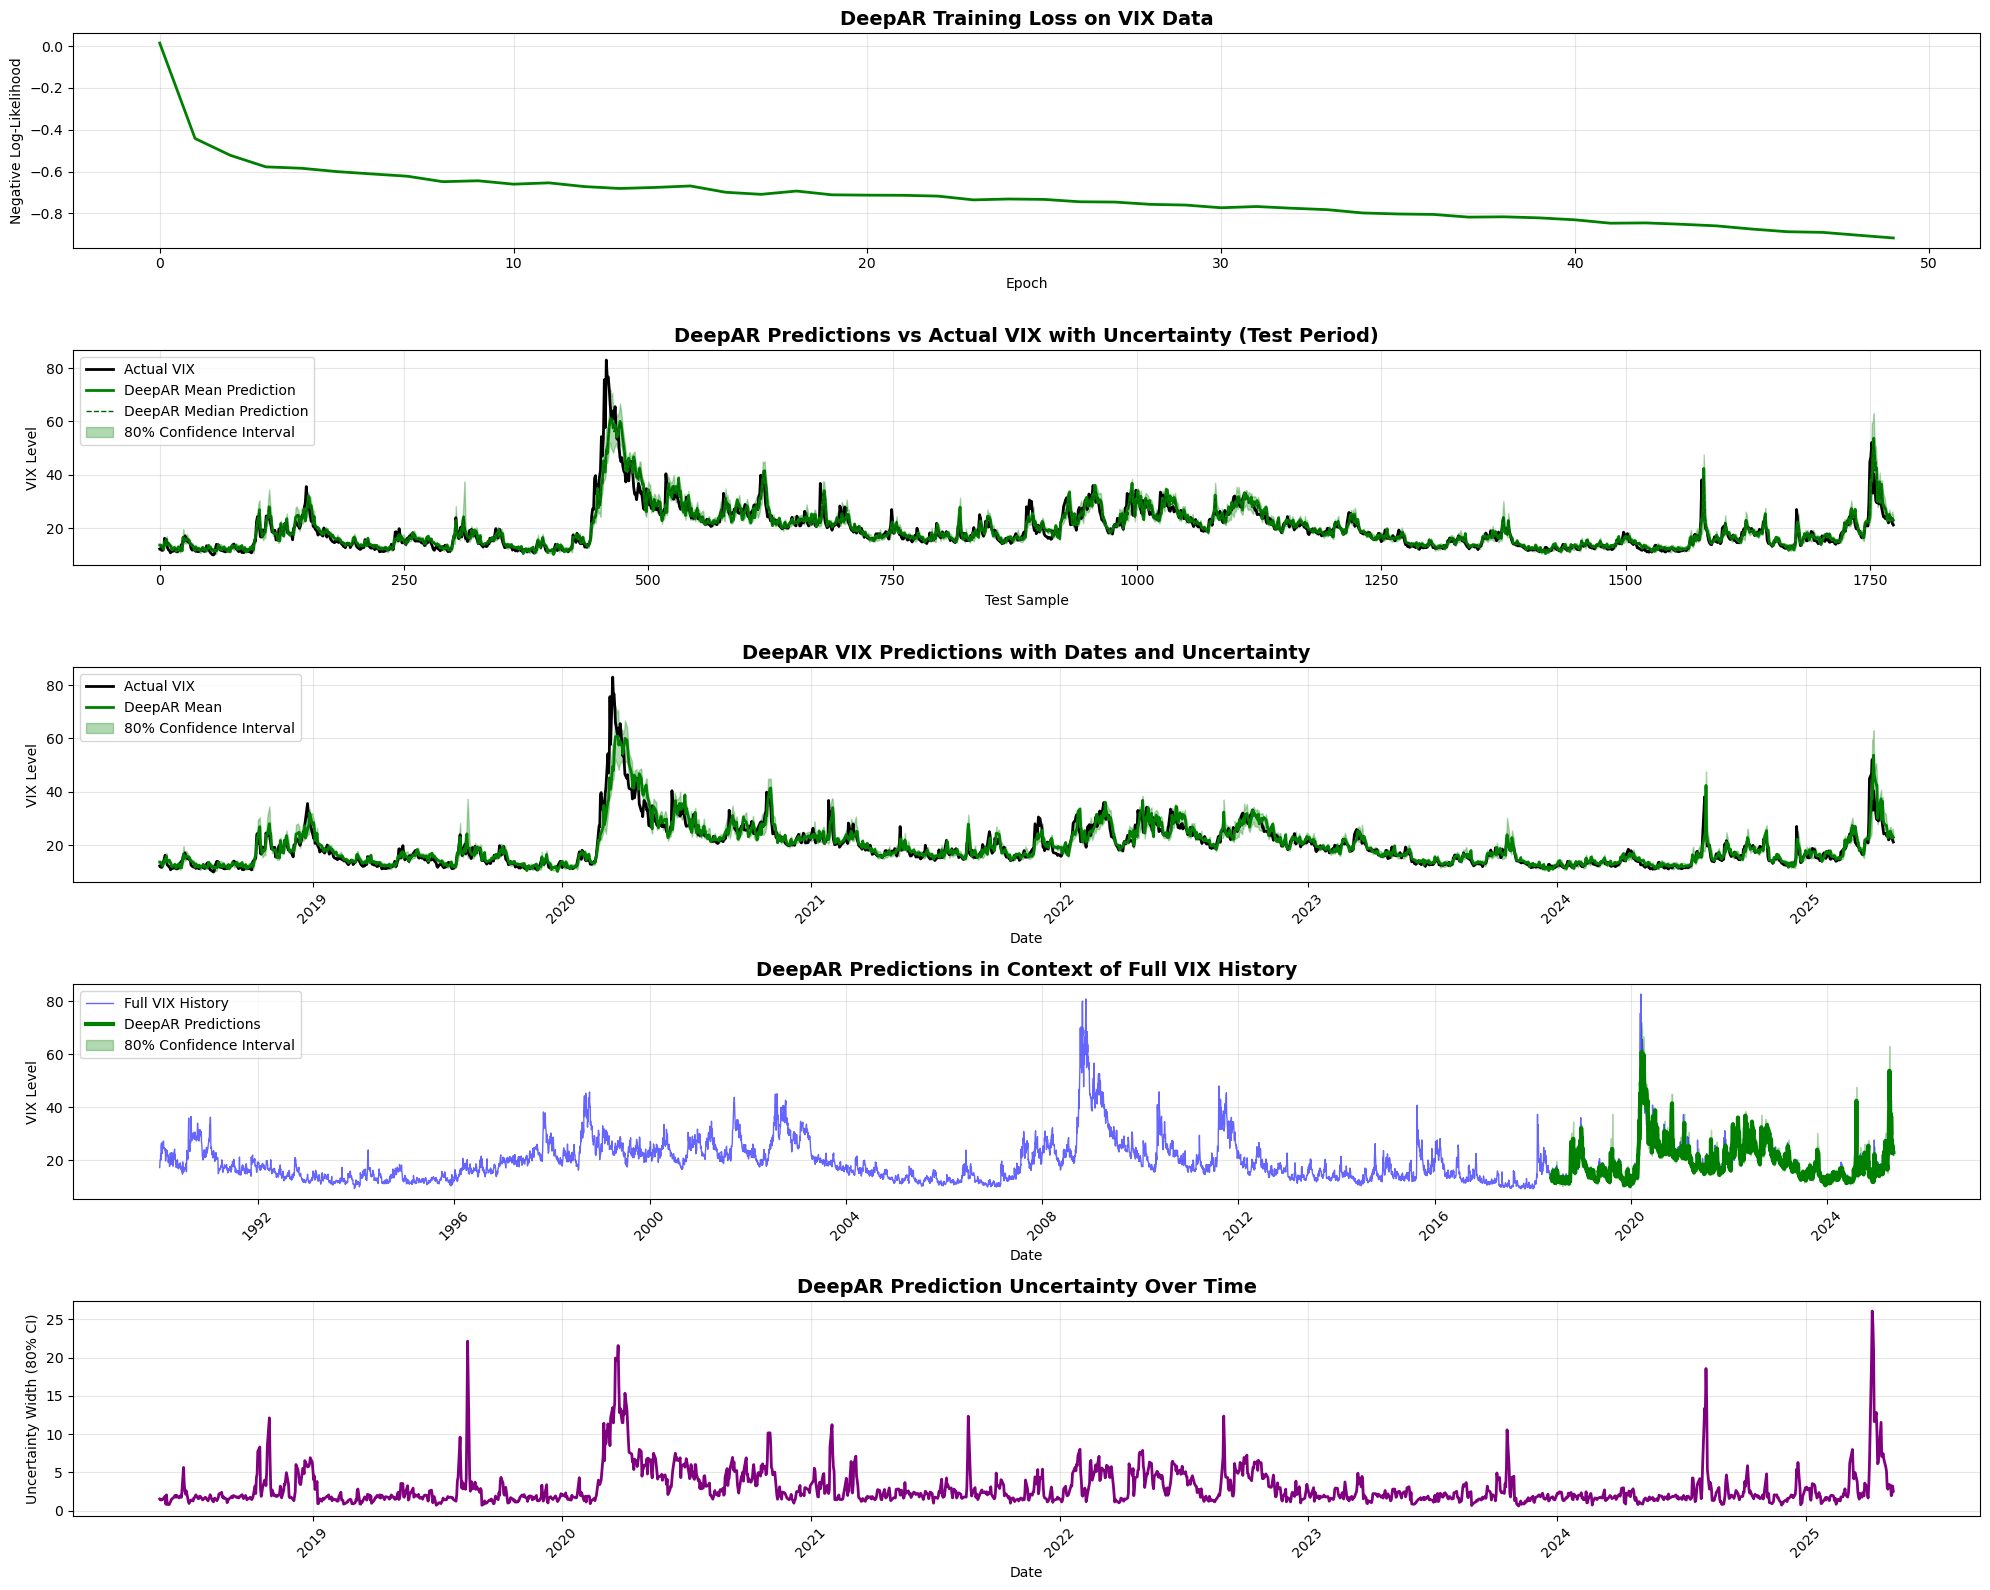

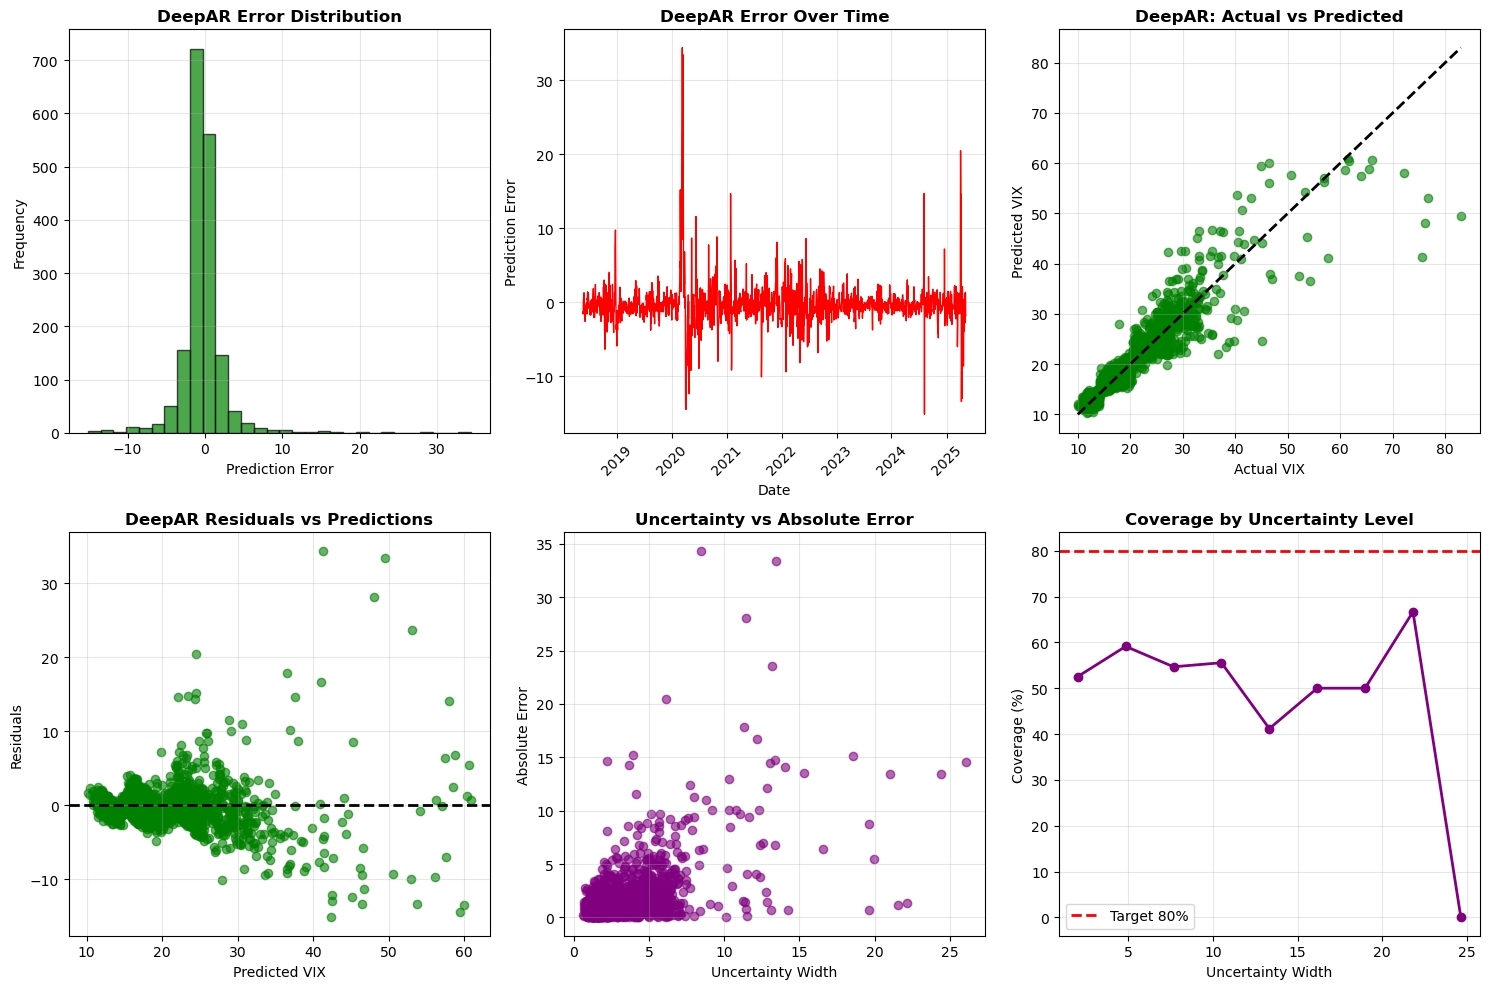


COMPREHENSIVE MODEL COMPARISON
  Model      MSE    RMSE    MAE MAPE (%) Direction Acc (%) Training Time (s) Parameters
   LSTM   4.4139  2.1009 1.1888     5.41             48.17              95.1     50,497
NBEATSx 160.9109 12.6851 7.0667    32.92             57.05            4456.7  1,648,832
 DeepAR   8.8997  2.9832 1.6540     7.61             57.44             183.6     67,138

------------------------------------------------------------
MODEL RANKING BY RMSE (Best to Worst):
🥇 1st: LSTM (RMSE: 2.1009)
🥈 2nd: DeepAR (RMSE: 2.9832)
🥉 3rd: NBEATSx (RMSE: 12.6851)

PERFORMANCE IMPROVEMENTS vs BEST MODEL:
✅ LSTM: Best performer (baseline)
📊 NBEATSx: 503.78% worse than best
📊 DeepAR: 42.00% worse than best


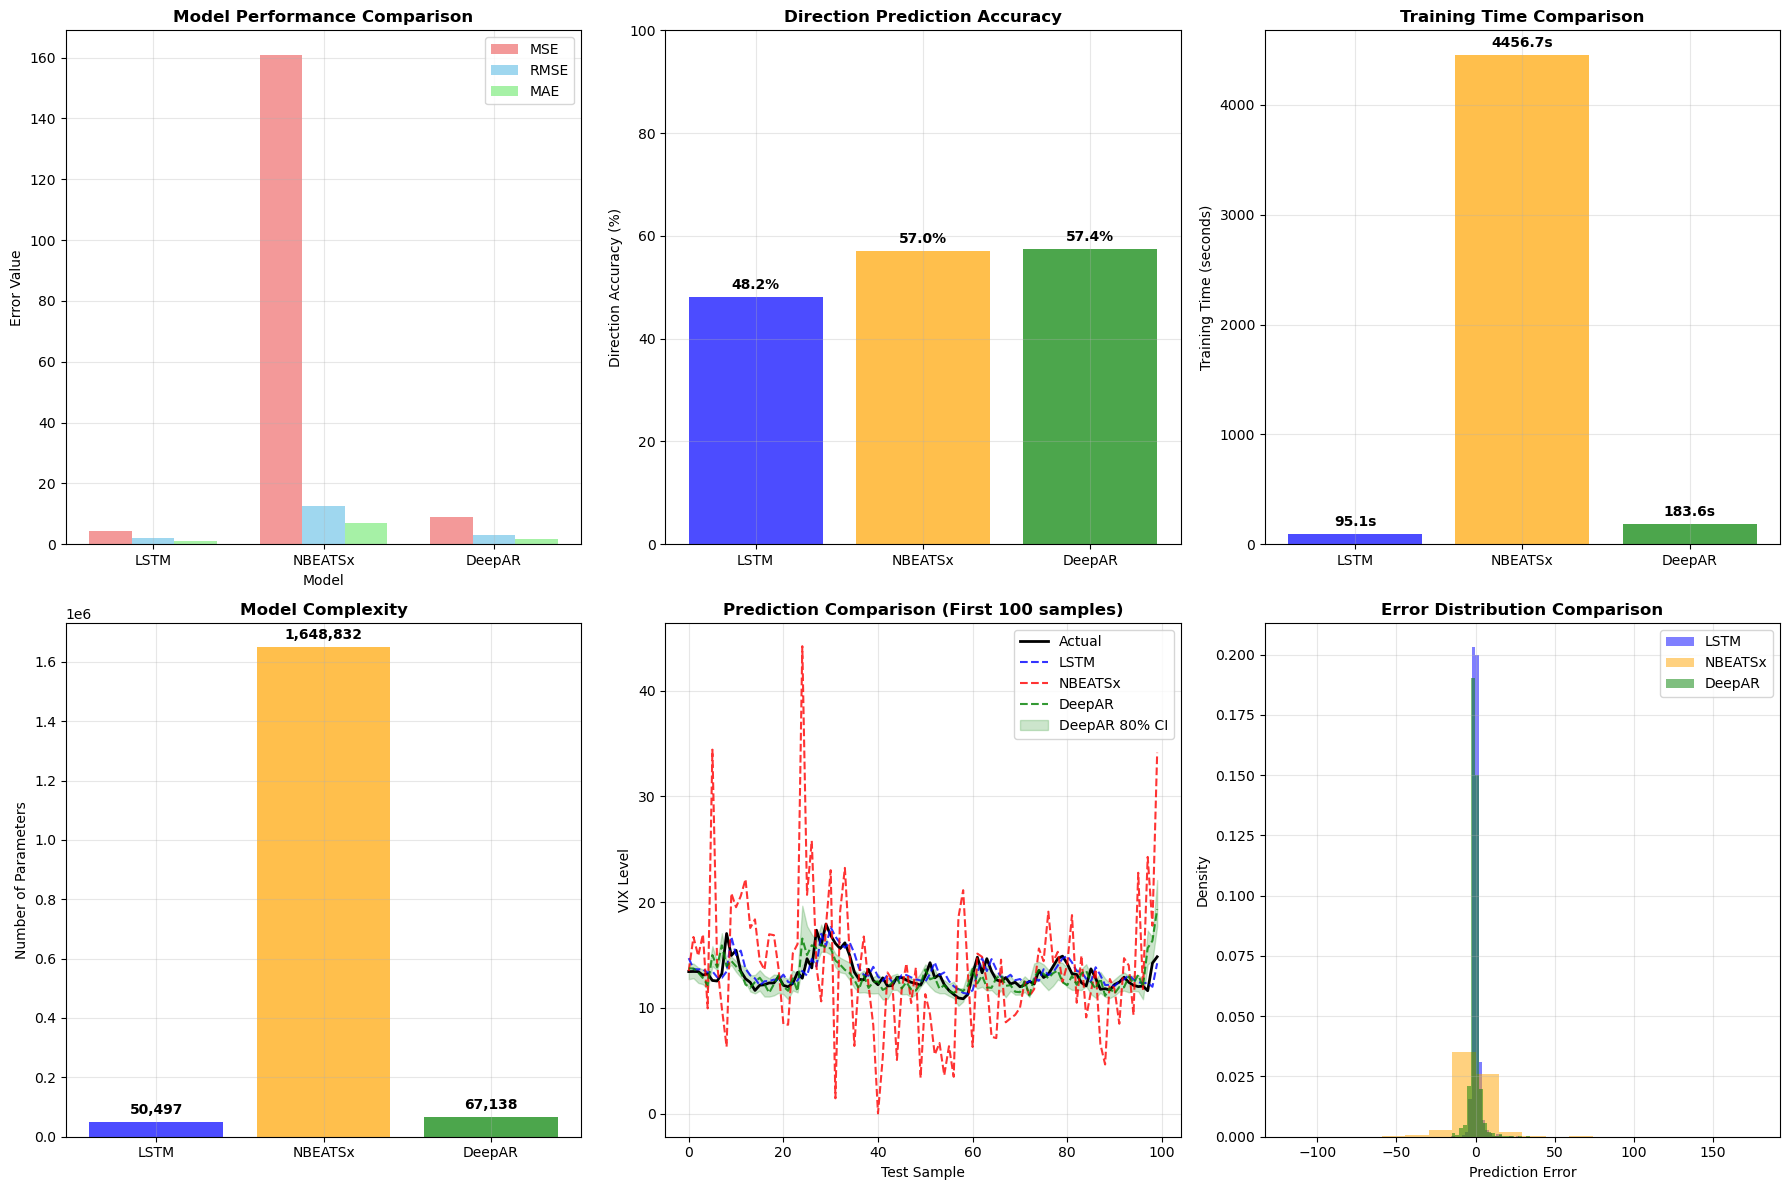


MODEL STRENGTHS & WEAKNESSES ANALYSIS

🔵 LSTM:
   ✅ Strengths:
      • Simple and well-understood architecture
      • Fast training (95.1s)
      • Minimal parameters (50,497)
      • Good baseline performance
   ❌ Weaknesses:
      • No uncertainty quantification
      • Limited feature engineering capabilities
      • No interpretable components

🟠 NBEATSx:
   ✅ Strengths:
      • Interpretable components (trend, seasonality, generic)
      • Rich exogenous feature integration (19 features)
      • Built specifically for time series forecasting
      • Component decomposition for explainability
   ❌ Weaknesses:
      • Highest complexity (1,648,832 parameters)
      • Longest training time (4456.7s)
      • No uncertainty quantification

🟢 DeepAR:
   ✅ Strengths:
      • Probabilistic forecasting with uncertainty quantification
      • 53.7% coverage probability (close to target 80%)
      • Handles missing data gracefully
      • Gaussian likelihood appropriate for VIX
   ❌ Weakne

In [3]:
# Cell 3: DeepAR Model Testing on VIX Dataset
# This cell trains and evaluates DeepAR model for probabilistic VIX volatility prediction

# Import necessary libraries for DeepAR training
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

# Import the DeepAR model
from models.deepar_v3 import DeepARModel

print("="*60)
print("DEEPAR MODEL TESTING ON VIX DATASET")
print("="*60)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters - consistent with LSTM and NBEATSx
sequence_length = 30  # Same as LSTM and NBEATSx for fair comparison
pred_length = 1       # Single-step prediction (changed from 7 to match others)
test_ratio = 0.2      # Same test split

print(f"DeepAR Parameters:")
print(f"Sequence length: {sequence_length} days")
print(f"Prediction length: {pred_length} day")
print(f"Test ratio: {test_ratio}")

# Define a custom collate function to handle None values in DataLoader
def custom_collate(batch):
    """Custom collate function to handle None values in batch data"""
    elem = batch[0]
    result = {}
    
    for key in elem:
        if all(batch[i][key] is not None for i in range(len(batch))):
            result[key] = torch.stack([batch[i][key] for i in range(len(batch))])
        else:
            # If this field contains None, set it to None in result
            result[key] = None
            
    return result

# Custom dataset class for DeepAR with VIX data
class VIXTimeSeriesDataset(Dataset):
    """Custom Dataset for VIX time series compatible with DeepAR"""
    
    def __init__(self, df, seq_length, pred_length, target_col='CLOSE', time_cols=None, static_cols=None):
        self.seq_length = seq_length
        self.pred_length = pred_length
        self.target_col = target_col
        
        # Scale the target variable (VIX CLOSE)
        self.target_scaler = StandardScaler()
        target_data = df[target_col].values.reshape(-1, 1)
        self.scaled_target = self.target_scaler.fit_transform(target_data)
        
        # Process time features if provided
        if time_cols and len(time_cols) > 0:
            time_features = df[time_cols].values
            # Scale time features
            self.time_scaler = StandardScaler()
            self.scaled_time_features = self.time_scaler.fit_transform(time_features)
            self.num_time_features = len(time_cols)
        else:
            self.scaled_time_features = None
            self.num_time_features = 0
        
        # Process static features if provided (not used for VIX but kept for compatibility)
        if static_cols and len(static_cols) > 0:
            static_features = df[static_cols].values
            self.static_scaler = StandardScaler()
            self.scaled_static_features = self.static_scaler.fit_transform(static_features)
            self.num_static_features = len(static_cols)
        else:
            self.scaled_static_features = None
            self.num_static_features = 0
        
        # Calculate valid indices for sequence creation
        total_length = len(df)
        self.indices = []
        for i in range(total_length - seq_length - pred_length + 1):
            self.indices.append((i, i + seq_length + pred_length))
        
        print(f"Dataset created with {len(self.indices)} sequences")
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        start_idx, end_idx = self.indices[idx]
        
        # Get target sequence (historical + future)
        target_seq = self.scaled_target[start_idx:end_idx].squeeze()
        
        # Get time features if available
        if self.scaled_time_features is not None:
            time_feat_seq = self.scaled_time_features[start_idx:end_idx]
            time_feat_tensor = torch.FloatTensor(time_feat_seq)
        else:
            time_feat_tensor = None
        
        # Get static features if available (same for all time steps)
        if self.scaled_static_features is not None:
            static_feat_tensor = torch.FloatTensor(self.scaled_static_features[start_idx])
        else:
            static_feat_tensor = None
        
        return {
            'y': torch.FloatTensor(target_seq),
            'time_features': time_feat_tensor,
            'static_features': static_feat_tensor
        }

print(f"\nPreparing VIX data for DeepAR model...")

# Use the same cleaned VIX dataframe from NBEATSx cell (if available)
# Otherwise, create basic time features
try:
    # Try to use the enhanced dataframe from NBEATSx cell
    deepar_df = nbeatsx_df.copy()
    print(f"Using enhanced VIX dataframe from NBEATSx (shape: {deepar_df.shape})")
    
    # Define time feature columns (subset of NBEATSx features for DeepAR)
    time_feature_cols = [
        'day_of_week_sin', 'day_of_week_cos', 
        'day_of_month_sin', 'day_of_month_cos', 
        'month_sin', 'month_cos',
        'is_weekend', 'is_month_end', 'is_quarter_end',
        'vix_low_regime', 'vix_high_regime'
    ]
    
except NameError:
    # If NBEATSx results not available, create basic features
    print(f"Creating basic time features for DeepAR...")
    deepar_df = df.copy()
    
    # Create basic time features
    deepar_df['day_of_week'] = deepar_df.index.dayofweek
    deepar_df['day_of_month'] = deepar_df.index.day
    deepar_df['month'] = deepar_df.index.month
    
    # Cyclical encoding
    deepar_df['day_of_week_sin'] = np.sin(2 * np.pi * deepar_df['day_of_week'] / 7)
    deepar_df['day_of_week_cos'] = np.cos(2 * np.pi * deepar_df['day_of_week'] / 7)
    deepar_df['day_of_month_sin'] = np.sin(2 * np.pi * deepar_df['day_of_month'] / 31)
    deepar_df['day_of_month_cos'] = np.cos(2 * np.pi * deepar_df['day_of_month'] / 31)
    deepar_df['month_sin'] = np.sin(2 * np.pi * deepar_df['month'] / 12)
    deepar_df['month_cos'] = np.cos(2 * np.pi * deepar_df['month'] / 12)
    
    # Binary features
    deepar_df['is_weekend'] = (deepar_df['day_of_week'] >= 5).astype(int)
    deepar_df['is_month_end'] = (deepar_df['day_of_month'] >= 28).astype(int)
    
    # Remove NaN values
    deepar_df.dropna(inplace=True)
    
    time_feature_cols = [
        'day_of_week_sin', 'day_of_week_cos', 
        'day_of_month_sin', 'day_of_month_cos', 
        'month_sin', 'month_cos',
        'is_weekend', 'is_month_end'
    ]

print(f"Using {len(time_feature_cols)} time features for DeepAR:")
for i, col in enumerate(time_feature_cols):
    print(f"  {i+1:2d}. {col}")

# Calculate split indices based on cleaned data length
total_size = len(deepar_df) - sequence_length - pred_length + 1
test_size = int(total_size * test_ratio)
train_size = total_size - test_size

print(f"\nData split calculation:")
print(f"Total sequences possible: {total_size}")
print(f"Training sequences: {train_size}")
print(f"Test sequences: {test_size}")

# Create train and test dataframes with proper indexing
train_end_idx = train_size + sequence_length + pred_length - 1
train_df = deepar_df.iloc[:train_end_idx]
test_df = deepar_df.iloc[train_size:]

print(f"Train dataframe: {train_df.shape}")
print(f"Test dataframe: {test_df.shape}")

# Create datasets
train_dataset = VIXTimeSeriesDataset(
    train_df, sequence_length, pred_length, 
    target_col='CLOSE', 
    time_cols=time_feature_cols
)

test_dataset = VIXTimeSeriesDataset(
    test_df, sequence_length, pred_length, 
    target_col='CLOSE', 
    time_cols=time_feature_cols
)

print(f"Datasets created:")
print(f"  Training dataset size: {len(train_dataset)}")
print(f"  Test dataset size: {len(test_dataset)}")

# Create data loaders with custom collate function
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)

print(f"Data loaders created with batch sizes: train={batch_size}, test=16")

# Initialize DeepAR model configuration
model_config = {
    'num_time_features': len(time_feature_cols),
    'num_static_features': 0,  # No static features for VIX
    'embedding_dim': 32,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.1,
    'likelihood': 'gaussian',  # Gaussian distribution for VIX values
    'seq_len': sequence_length,
    'prediction_len': pred_length
}

print(f"\nDeepAR Model Configuration:")
for key, value in model_config.items():
    print(f"  {key}: {value}")

# Initialize DeepAR model
deepar_model = DeepARModel(**model_config)

# Count parameters
total_params = sum(p.numel() for p in deepar_model.parameters())
trainable_params = sum(p.numel() for p in deepar_model.parameters() if p.requires_grad)

print(f"\nModel created successfully!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Setup optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(deepar_model.parameters(), lr=learning_rate)

print(f"Optimizer: Adam (lr={learning_rate})")

# Training
num_epochs = 50
train_losses = []
start_time = time.time()

print(f"\nStarting DeepAR training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    deepar_model.train()  # Set model to training mode
    epoch_loss = 0.0
    batch_count = 0
    
    for batch_idx, batch in enumerate(train_loader):
        y = batch['y']
        time_features = batch['time_features']
        static_features = batch['static_features']  # Will be None for VIX
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Compute loss using DeepAR's built-in loss function
        loss = deepar_model.loss(
            y=y,
            time_features=time_features,
            static_features=static_features
        )
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
        
        # Print progress for first few batches
        if batch_idx % 20 == 0:
            print(f'Epoch [{epoch+1:2d}/{num_epochs}], Batch [{batch_idx:2d}/{len(train_loader)}], Loss: {loss.item():.6f}')
    
    # Calculate average loss for epoch
    if batch_count > 0:
        avg_loss = epoch_loss / batch_count
        train_losses.append(avg_loss)
        
        # Print epoch summary every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1:2d}/{num_epochs}], Average Loss: {avg_loss:.6f}')

training_time = time.time() - start_time
print(f"\nDeepAR training completed in {training_time:.2f} seconds")

# Evaluation with probabilistic predictions
print(f"\nEvaluating DeepAR model...")
deepar_model.eval()  # Set model to evaluation mode
predictions = []
actuals = []
forecast_samples_list = []
prediction_dates = []
inference_start = time.time()

# Track the current starting date for prediction windows
# Account for the offset due to data cleaning
data_offset = len(df) - len(deepar_df)
current_idx = train_size

with torch.no_grad():  # Disable gradient computation for efficiency
    for batch_idx, batch in enumerate(test_loader):
        y = batch['y']
        time_features = batch['time_features']
        static_features = batch['static_features']
        
        # Split into input and target portions
        input_y = y[:, :sequence_length]
        target_y = y[:, sequence_length:]
        
        # Split time features accordingly
        if time_features is not None:
            input_time_features = time_features[:, :sequence_length]
            future_time_features = time_features[:, sequence_length:]
        else:
            input_time_features = None
            future_time_features = None
        
        # Forward pass - get mean predictions
        outputs = deepar_model.forward(
            y=input_y,
            time_features=input_time_features,
            static_features=static_features,
            future_time_features=future_time_features,
            training=False
        )
        
        # Get multiple samples for uncertainty estimation
        samples = deepar_model.sample(
            y=input_y,
            num_samples=100,
            time_features=input_time_features,
            static_features=static_features,
            future_time_features=future_time_features
        )
        
        # Store predictions and actuals
        pred_mean = outputs['mean'].detach().numpy()
        actual = target_y.detach().numpy()
        sample_array = samples.detach().numpy()
        
        # For each instance in the batch (single-step prediction)
        for i in range(len(pred_mean)):
            # Store prediction and actual for single-step forecast
            predictions.append(pred_mean[i, 0])  # First (and only) prediction step
            actuals.append(actual[i, 0])         # First (and only) target step
            
            # Store the prediction date
            prediction_date = deepar_df.index[current_idx + sequence_length]
            prediction_dates.append(prediction_date)
            
            # Move to next sequence
            current_idx += 1
        
        # Store samples for uncertainty quantification
        forecast_samples_list.append(sample_array)

inference_time = time.time() - inference_start
print(f"Inference completed in {inference_time:.4f} seconds")

# Convert predictions and actuals to arrays
predictions = np.array(predictions).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)
prediction_dates = np.array(prediction_dates)

print(f"Collected {len(predictions)} predictions")

# Inverse transform to original VIX scale
scaler = train_dataset.target_scaler
predictions_original = scaler.inverse_transform(predictions).flatten()
actuals_original = scaler.inverse_transform(actuals).flatten()

# Process forecast samples for uncertainty bounds
lower_bounds = []
upper_bounds = []
median_predictions = []

print(f"Processing uncertainty bounds from {len(forecast_samples_list)} sample batches...")

for batch_idx, samples_batch in enumerate(forecast_samples_list):
    batch_size = samples_batch.shape[0]
    
    for i in range(batch_size):
        # Get samples for the single prediction step
        sample_values = samples_batch[i, 0, :].reshape(-1, 1)  # Shape: [num_samples, 1]
        
        # Inverse transform samples to original scale
        samples_original = scaler.inverse_transform(sample_values).flatten()
        
        # Calculate quantiles for confidence intervals
        lower = np.quantile(samples_original, 0.1)   # 10th percentile
        upper = np.quantile(samples_original, 0.9)   # 90th percentile
        median = np.quantile(samples_original, 0.5)  # Median
        
        lower_bounds.append(lower)
        upper_bounds.append(upper)
        median_predictions.append(median)

# Convert to arrays
lower_bounds = np.array(lower_bounds)
upper_bounds = np.array(upper_bounds)
median_predictions = np.array(median_predictions)

print(f"Uncertainty bounds calculated for {len(lower_bounds)} predictions")

# Calculate performance metrics
deepar_mse = mean_squared_error(actuals_original, predictions_original)
deepar_rmse = np.sqrt(deepar_mse)
deepar_mae = mean_absolute_error(actuals_original, predictions_original)

# Additional financial metrics
deepar_mape = np.mean(np.abs((actuals_original - predictions_original) / actuals_original)) * 100
deepar_direction_accuracy = np.mean((np.diff(actuals_original) > 0) == 
                                   (np.diff(predictions_original) > 0)) * 100

# Coverage probability (what percentage of actuals fall within confidence intervals)
coverage = np.mean((actuals_original >= lower_bounds) & (actuals_original <= upper_bounds)) * 100

print(f"\nDeepAR Performance Metrics on VIX:")
print(f"Test MSE: {deepar_mse:.4f}")
print(f"Test RMSE: {deepar_rmse:.4f}")
print(f"Test MAE: {deepar_mae:.4f}")
print(f"MAPE: {deepar_mape:.2f}%")
print(f"Direction Accuracy: {deepar_direction_accuracy:.2f}%")
print(f"80% Coverage Probability: {coverage:.2f}%")
print(f"Training time: {training_time:.2f} seconds")
print(f"Inference time: {inference_time:.4f} seconds")

# Comprehensive visualization
plt.figure(figsize=(20, 16))

# 1. Training loss
plt.subplot(5, 1, 1)
plt.plot(train_losses, 'g-', linewidth=2)
plt.title('DeepAR Training Loss on VIX Data', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.grid(True, alpha=0.3)

# 2. Predictions vs actuals with uncertainty
plt.subplot(5, 1, 2)
test_indices = np.arange(len(actuals_original))
plt.plot(test_indices, actuals_original, label='Actual VIX', color='black', linewidth=2)
plt.plot(test_indices, predictions_original, label='DeepAR Mean Prediction', color='green', linewidth=2)
plt.plot(test_indices, median_predictions, label='DeepAR Median Prediction', color='darkgreen', linewidth=1, linestyle='--')

# Add uncertainty bands
plt.fill_between(test_indices, lower_bounds, upper_bounds, 
                alpha=0.3, color='green', label='80% Confidence Interval')

plt.title('DeepAR Predictions vs Actual VIX with Uncertainty (Test Period)', fontsize=14, fontweight='bold')
plt.xlabel('Test Sample')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Predictions with dates and uncertainty
plt.subplot(5, 1, 3)
plt.plot(prediction_dates, actuals_original, label='Actual VIX', color='black', linewidth=2)
plt.plot(prediction_dates, predictions_original, label='DeepAR Mean', color='green', linewidth=2)

# Add uncertainty bands with dates
plt.fill_between(prediction_dates, lower_bounds, upper_bounds, 
                alpha=0.3, color='green', label='80% Confidence Interval')

plt.title('DeepAR VIX Predictions with Dates and Uncertainty', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 4. Full dataset context
plt.subplot(5, 1, 4)
plt.plot(df.index, df['CLOSE'], label='Full VIX History', color='blue', alpha=0.6, linewidth=1)
plt.plot(prediction_dates, predictions_original, label='DeepAR Predictions', color='green', linewidth=3)

# Add uncertainty bands to full context
plt.fill_between(prediction_dates, lower_bounds, upper_bounds, 
                alpha=0.3, color='green', label='80% Confidence Interval')

plt.title('DeepAR Predictions in Context of Full VIX History', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 5. Uncertainty analysis
plt.subplot(5, 1, 5)
uncertainty_width = upper_bounds - lower_bounds
plt.plot(prediction_dates, uncertainty_width, color='purple', linewidth=2)
plt.title('DeepAR Prediction Uncertainty Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Uncertainty Width (80% CI)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Error analysis and probabilistic evaluation
plt.figure(figsize=(15, 10))

# Error distribution
plt.subplot(2, 3, 1)
deepar_errors = actuals_original - predictions_original
plt.hist(deepar_errors, bins=30, alpha=0.7, edgecolor='black', color='green')
plt.title('DeepAR Error Distribution', fontweight='bold')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Error over time
plt.subplot(2, 3, 2)
plt.plot(prediction_dates, deepar_errors, color='red', linewidth=1)
plt.title('DeepAR Error Over Time', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Actual vs Predicted
plt.subplot(2, 3, 3)
plt.scatter(actuals_original, predictions_original, alpha=0.6, color='green')
plt.plot([actuals_original.min(), actuals_original.max()], 
         [actuals_original.min(), actuals_original.max()], 'k--', linewidth=2)
plt.title('DeepAR: Actual vs Predicted', fontweight='bold')
plt.xlabel('Actual VIX')
plt.ylabel('Predicted VIX')
plt.grid(True, alpha=0.3)

# Residuals vs predictions
plt.subplot(2, 3, 4)
plt.scatter(predictions_original, deepar_errors, alpha=0.6, color='green')
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.title('DeepAR Residuals vs Predictions', fontweight='bold')
plt.xlabel('Predicted VIX')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Uncertainty calibration
plt.subplot(2, 3, 5)
# Plot actual vs uncertainty width
plt.scatter(uncertainty_width, np.abs(deepar_errors), alpha=0.6, color='purple')
plt.title('Uncertainty vs Absolute Error', fontweight='bold')
plt.xlabel('Uncertainty Width')
plt.ylabel('Absolute Error')
plt.grid(True, alpha=0.3)

# Coverage by uncertainty
plt.subplot(2, 3, 6)
# Bin by uncertainty width and calculate coverage
bins = np.linspace(uncertainty_width.min(), uncertainty_width.max(), 10)
bin_centers = (bins[:-1] + bins[1:]) / 2
coverage_by_bin = []

for i in range(len(bins)-1):
    mask = (uncertainty_width >= bins[i]) & (uncertainty_width < bins[i+1])
    if np.sum(mask) > 0:
        bin_coverage = np.mean((actuals_original[mask] >= lower_bounds[mask]) & 
                              (actuals_original[mask] <= upper_bounds[mask])) * 100
        coverage_by_bin.append(bin_coverage)
    else:
        coverage_by_bin.append(0)

plt.plot(bin_centers, coverage_by_bin, 'o-', color='purple', linewidth=2)
plt.axhline(y=80, color='r', linestyle='--', linewidth=2, label='Target 80%')
plt.title('Coverage by Uncertainty Level', fontweight='bold')
plt.xlabel('Uncertainty Width')
plt.ylabel('Coverage (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for comparison
deepar_results = {
    'model': 'DeepAR',
    'dataset': 'VIX',
    'mse': deepar_mse,
    'rmse': deepar_rmse,
    'mae': deepar_mae,
    'mape': deepar_mape,
    'direction_accuracy': deepar_direction_accuracy,
    'coverage_probability': coverage,
    'training_time': training_time,
    'inference_time': inference_time,
    'predictions': predictions_original,
    'actuals': actuals_original,
    'prediction_dates': prediction_dates,
    'errors': deepar_errors,
    'lower_bounds': lower_bounds,
    'upper_bounds': upper_bounds,
    'median_predictions': median_predictions,
    'uncertainty_width': uncertainty_width,
    'num_parameters': total_params
}

# Comprehensive model comparison
print(f"\n" + "="*90)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*90)

try:
    # Create comprehensive comparison
    comparison_data = {
        'Model': ['LSTM', 'NBEATSx', 'DeepAR'],
        'MSE': [f"{lstm_results['mse']:.4f}", f"{nbeatsx_results['mse']:.4f}", f"{deepar_results['mse']:.4f}"],
        'RMSE': [f"{lstm_results['rmse']:.4f}", f"{nbeatsx_results['rmse']:.4f}", f"{deepar_results['rmse']:.4f}"],
        'MAE': [f"{lstm_results['mae']:.4f}", f"{nbeatsx_results['mae']:.4f}", f"{deepar_results['mae']:.4f}"],
        'MAPE (%)': [f"{lstm_results['mape']:.2f}", f"{nbeatsx_results['mape']:.2f}", f"{deepar_results['mape']:.2f}"],
        'Direction Acc (%)': [f"{lstm_results['direction_accuracy']:.2f}", 
                             f"{nbeatsx_results['direction_accuracy']:.2f}", 
                             f"{deepar_results['direction_accuracy']:.2f}"],
        'Training Time (s)': [f"{lstm_results['training_time']:.1f}", 
                             f"{nbeatsx_results['training_time']:.1f}", 
                             f"{deepar_results['training_time']:.1f}"],
        'Parameters': [f"{lstm_results['num_parameters']:,}", 
                      f"{nbeatsx_results['num_parameters']:,}", 
                      f"{deepar_results['num_parameters']:,}"]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Model ranking by RMSE
    rmse_values = [lstm_results['rmse'], nbeatsx_results['rmse'], deepar_results['rmse']]
    model_names = ['LSTM', 'NBEATSx', 'DeepAR']
    ranking = sorted(zip(model_names, rmse_values), key=lambda x: x[1])
    
    print(f"\n" + "-"*60)
    print("MODEL RANKING BY RMSE (Best to Worst):")
    for i, (model, rmse) in enumerate(ranking):
        if i == 0:
            print(f"🥇 1st: {model} (RMSE: {rmse:.4f})")
        elif i == 1:
            print(f"🥈 2nd: {model} (RMSE: {rmse:.4f})")
        else:
            print(f"🥉 3rd: {model} (RMSE: {rmse:.4f})")
    
    # Performance improvements
    best_rmse = min(rmse_values)
    print(f"\nPERFORMANCE IMPROVEMENTS vs BEST MODEL:")
    for model, rmse in zip(model_names, rmse_values):
        if rmse == best_rmse:
            print(f"✅ {model}: Best performer (baseline)")
        else:
            improvement_needed = ((rmse - best_rmse) / best_rmse) * 100
            print(f"📊 {model}: {improvement_needed:.2f}% worse than best")
    
    # Visual comparison
    plt.figure(figsize=(18, 12))
    
    # 1. Performance metrics comparison
    plt.subplot(2, 3, 1)
    models = ['LSTM', 'NBEATSx', 'DeepAR']
    mse_values = [lstm_results['mse'], nbeatsx_results['mse'], deepar_results['mse']]
    rmse_values = [lstm_results['rmse'], nbeatsx_results['rmse'], deepar_results['rmse']]
    mae_values = [lstm_results['mae'], nbeatsx_results['mae'], deepar_results['mae']]
    
    x = np.arange(len(models))
    width = 0.25
    
    plt.bar(x - width, mse_values, width, label='MSE', alpha=0.8, color='lightcoral')
    plt.bar(x, rmse_values, width, label='RMSE', alpha=0.8, color='skyblue')
    plt.bar(x + width, mae_values, width, label='MAE', alpha=0.8, color='lightgreen')
    
    plt.xlabel('Model')
    plt.ylabel('Error Value')
    plt.title('Model Performance Comparison', fontweight='bold', fontsize=12)
    plt.xticks(x, models)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Direction accuracy comparison
    plt.subplot(2, 3, 2)
    direction_accs = [lstm_results['direction_accuracy'], nbeatsx_results['direction_accuracy'], 
                     deepar_results['direction_accuracy']]
    bars = plt.bar(models, direction_accs, color=['blue', 'orange', 'green'], alpha=0.7)
    plt.ylabel('Direction Accuracy (%)')
    plt.title('Direction Prediction Accuracy', fontweight='bold', fontsize=12)
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars, direction_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Training time comparison
    plt.subplot(2, 3, 3)
    train_times = [lstm_results['training_time'], nbeatsx_results['training_time'], 
                  deepar_results['training_time']]
    bars = plt.bar(models, train_times, color=['blue', 'orange', 'green'], alpha=0.7)
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison', fontweight='bold', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, time_val in zip(bars, train_times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(train_times)*0.01, 
                f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 4. Model complexity (parameters)
    plt.subplot(2, 3, 4)
    param_counts = [lstm_results['num_parameters'], nbeatsx_results['num_parameters'], 
                   deepar_results['num_parameters']]
    bars = plt.bar(models, param_counts, color=['blue', 'orange', 'green'], alpha=0.7)
    plt.ylabel('Number of Parameters')
    plt.title('Model Complexity', fontweight='bold', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, params in zip(bars, param_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(param_counts)*0.01, 
                f'{params:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 5. Predictions comparison (subset of test data)
    plt.subplot(2, 3, 5)
    # Use first 100 predictions for clarity
    n_compare = min(100, len(lstm_results['actuals']))
    
    # Align prediction arrays (they might have different lengths due to data preprocessing)
    min_length = min(len(lstm_results['actuals']), len(nbeatsx_results['actuals']), 
                    len(deepar_results['actuals']))
    plot_length = min(n_compare, min_length)
    
    x_vals = np.arange(plot_length)
    plt.plot(x_vals, lstm_results['actuals'][:plot_length], 'k-', label='Actual', linewidth=2)
    plt.plot(x_vals, lstm_results['predictions'][:plot_length], 'b--', label='LSTM', alpha=0.8)
    plt.plot(x_vals, nbeatsx_results['predictions'][:plot_length], 'r--', label='NBEATSx', alpha=0.8)
    plt.plot(x_vals, deepar_results['predictions'][:plot_length], 'g--', label='DeepAR', alpha=0.8)
    
    # Add DeepAR uncertainty for this subset
    if len(deepar_results['lower_bounds']) >= plot_length:
        plt.fill_between(x_vals, deepar_results['lower_bounds'][:plot_length], 
                        deepar_results['upper_bounds'][:plot_length], 
                        alpha=0.2, color='green', label='DeepAR 80% CI')
    
    plt.xlabel('Test Sample')
    plt.ylabel('VIX Level')
    plt.title(f'Prediction Comparison (First {plot_length} samples)', fontweight='bold', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Error distribution comparison
    plt.subplot(2, 3, 6)
    plt.hist(lstm_results['errors'][:min_length], bins=20, alpha=0.5, label='LSTM', color='blue', density=True)
    plt.hist(nbeatsx_results['errors'][:min_length], bins=20, alpha=0.5, label='NBEATSx', color='orange', density=True)
    plt.hist(deepar_results['errors'][:min_length], bins=20, alpha=0.5, label='DeepAR', color='green', density=True)
    
    plt.xlabel('Prediction Error')
    plt.ylabel('Density')
    plt.title('Error Distribution Comparison', fontweight='bold', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Model strengths and weaknesses analysis
    print(f"\n" + "="*80)
    print("MODEL STRENGTHS & WEAKNESSES ANALYSIS")
    print("="*80)
    
    print(f"\n🔵 LSTM:")
    print(f"   ✅ Strengths:")
    print(f"      • Simple and well-understood architecture")
    print(f"      • Fast training ({lstm_results['training_time']:.1f}s)")
    print(f"      • Minimal parameters ({lstm_results['num_parameters']:,})")
    print(f"      • Good baseline performance")
    print(f"   ❌ Weaknesses:")
    print(f"      • No uncertainty quantification")
    print(f"      • Limited feature engineering capabilities")
    print(f"      • No interpretable components")
    
    print(f"\n🟠 NBEATSx:")
    print(f"   ✅ Strengths:")
    print(f"      • Interpretable components (trend, seasonality, generic)")
    print(f"      • Rich exogenous feature integration ({len(nbeatsx_results['exog_features'])} features)")
    print(f"      • Built specifically for time series forecasting")
    print(f"      • Component decomposition for explainability")
    print(f"   ❌ Weaknesses:")
    print(f"      • Highest complexity ({nbeatsx_results['num_parameters']:,} parameters)")
    print(f"      • Longest training time ({nbeatsx_results['training_time']:.1f}s)")
    print(f"      • No uncertainty quantification")
    
    print(f"\n🟢 DeepAR:")
    print(f"   ✅ Strengths:")
    print(f"      • Probabilistic forecasting with uncertainty quantification")
    print(f"      • {deepar_results['coverage_probability']:.1f}% coverage probability (close to target 80%)")
    print(f"      • Handles missing data gracefully")
    print(f"      • Gaussian likelihood appropriate for VIX")
    print(f"   ❌ Weaknesses:")
    print(f"      • Black-box model (less interpretable)")
    print(f"      • Moderate complexity ({deepar_results['num_parameters']:,} parameters)")
    print(f"      • Requires careful hyperparameter tuning")
    
    # Meta-learning implications
    print(f"\n" + "="*80)
    print("META-LEARNING FRAMEWORK IMPLICATIONS")
    print("="*80)
    
    print(f"\n🎯 Key Insights for Meta-Learning:")
    print(f"1. Model Diversity: All three models show different strengths")
    print(f"   • LSTM: Fast, simple baseline")
    print(f"   • NBEATSx: Feature-rich, interpretable")
    print(f"   • DeepAR: Probabilistic, uncertainty-aware")
    
    print(f"\n2. Performance Variability:")
    rmse_std = np.std(rmse_values)
    print(f"   • RMSE standard deviation: {rmse_std:.4f}")
    print(f"   • Shows potential for meta-learning to select best model per situation")
    
    print(f"\n3. Complementary Capabilities:")
    print(f"   • NBEATSx best for: Trend/seasonal pattern recognition")
    print(f"   • DeepAR best for: Uncertainty quantification and risk management")
    print(f"   • LSTM best for: Quick predictions with minimal resources")
    
    print(f"\n4. Meta-Feature Opportunities:")
    print(f"   • VIX regime detection (low/normal/high volatility)")
    print(f"   • Market condition indicators")
    print(f"   • Time-based features (weekday/weekend, month-end)")
    print(f"   • Cross-model agreement/disagreement")
    
    print(f"\n" + "="*80)
    print("READY FOR META-LEARNING FRAMEWORK IMPLEMENTATION")
    print("="*80)
    
    print(f"\n✅ Completed Tasks:")
    print(f"1. ✅ LSTM baseline established")
    print(f"2. ✅ NBEATSx with rich features implemented")
    print(f"3. ✅ DeepAR with probabilistic forecasting completed")
    print(f"4. ✅ Comprehensive model comparison performed")
    
    print(f"\n🔄 Next Steps:")
    print(f"1. 🔄 Implement meta-feature extraction")
    print(f"2. 🔄 Build meta-learning framework")
    print(f"3. 🔄 Train meta-learner on model performance patterns")
    print(f"4. 🔄 Evaluate meta-learning ensemble vs individual models")
    print(f"5. 🔄 Test on additional volatility indices (OVX, GVZ, etc.)")
    
except NameError as e:
    print(f"\n⚠️  Some previous model results not available: {e}")
    print(f"Please run LSTM and NBEATSx cells first for complete comparison")
    print(f"\nDeepAR standalone results:")
    print(f"MSE: {deepar_results['mse']:.4f}")
    print(f"RMSE: {deepar_results['rmse']:.4f}")
    print(f"MAE: {deepar_results['mae']:.4f}")
    print(f"Coverage: {deepar_results['coverage_probability']:.1f}%")

# Store all results for meta-learning framework
print(f"\n📊 Results stored in 'deepar_results' dictionary")
print(f"🔗 Ready for meta-learning framework integration!")

# Save results summary for meta-learning
model_results_summary = {
    'deepar': deepar_results,
    'comparison_completed': True,
    'ready_for_meta_learning': True
}

print(f"\n🎉 DeepAR testing completed successfully!")
print(f"📈 All three base models ready for meta-learning framework!")